# 已知H0或H1下檢定(1,1),(2,2),...,(L,L)

 - 維持用常態當作輸入

- - input1_i v.s. input2_i

In [ ]:
# ====== Per-block (27 BasicBlocks) power/type-I estimation for 5 tests (t, MW, KS, CvM, AD) ======
import os, sys
import torch
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu, ks_2samp, cramervonmises_2samp, anderson_ksamp

# ---------- Repro & device ----------
torch.manual_seed(0)
np.random.seed(0)
device = torch.device("cpu")

# ---------- Load CIFAR-ResNet56 (your repo) ----------
# 改成你的 resnet_cifar10.py 所在資料夾
sys.path.append("/ssd5/Roy/pruning/pytorch_resnet_cifar10-master")  # <-- 修改成你的路徑
import resnet_cifar10

arch = "resnet56"
model = resnet_cifar10.__dict__[arch]()
ckpt_path = "/ssd5/Roy/pruning/pytorch_resnet_cifar10-master/pretrained_models/resnet56.th"  # <-- 修改成你的路徑
ckpt = torch.load(ckpt_path, map_location="cpu")
state_dict = {k.replace("module.", ""): v for k, v in ckpt["state_dict"].items()}
model.load_state_dict(state_dict)
model.to(device).eval()

# ---------- Hook only 27 BasicBlocks (layer1/layer2/layer3) ----------
activations = [None] * 27   # 固定長度 27
hooks = []

def make_hook(idx):
    def hook_fn(module, inp, out):
        # 存 CPU tensor；不要在 hook 內轉 numpy，避免各種環境/記憶體問題
        activations[idx] = out.detach().cpu()
    return hook_fn

idx = 0
for stage_name in ["layer1", "layer2", "layer3"]:
    layer = getattr(model, stage_name)            # nn.Sequential with 9 BasicBlocks
    for block in layer:                           # 9 blocks per layer
        hooks.append(block.register_forward_hook(make_hook(idx)))
        idx += 1

assert idx == 27, f"Expect 27 hooks but got {idx}"

def run_once(x: torch.Tensor):
    """Forward，一次回傳 27 個 block 的輸出（CPU tensors）。"""
    # reset
    for i in range(27):
        activations[i] = None
    _ = model(x)
    # sanity
    for i, a in enumerate(activations):
        if a is None:
            raise RuntimeError(f"Block {i} did not produce activation.")
    # clone to avoid mutation
    return [a.clone() for a in activations]

def to_np(x: torch.Tensor):
    """安全轉 numpy 1D 向量"""
    return x.detach().cpu().contiguous().float().view(-1).numpy()

# ---------- Experiment config ----------
B = 100           # 迭代次數（H0 一百次 + H1 一百次）
alpha = 0.05
mean_shift = 5.0  # H1: N(0,1) vs N(mean_shift,1)
INPUT_SHAPE = (1, 3, 32, 32)

TESTS = ["t", "mw", "ks", "cvm", "ad"]
results = {t: {i: [] for i in range(27)} for t in TESTS}

def rand_logistic(size, loc=0.0, scale=1.0, device="cpu"):
    # U ~ Uniform(0,1)
    U = torch.rand(size, device=device)
    return loc + scale * torch.log(U / (1 - U))

def rand_exponential(size, lambd=1.0, device="cpu"):
    # PyTorch exponential_ 是取 rate=1/lambda
    # 這裡 lambd = rate
    return torch.empty(size, device=device).exponential_(lambd)

# ---------- H0: Type I error (N(0,1) vs N(0,1)) ----------
for _ in range(B):
    # x = torch.randn(*INPUT_SHAPE, device=device)
    # y = torch.randn(*INPUT_SHAPE, device=device)

    # x = rand_logistic(INPUT_SHAPE, loc=0.0, scale=1.0, device=device)
    # y = rand_logistic(INPUT_SHAPE, loc=0.0, scale=1.0, device=device)   # H0

    x = rand_exponential(INPUT_SHAPE, lambd=1.0, device=device)
    y = rand_exponential(INPUT_SHAPE, lambd=1.0, device=device)   # H0

    acts_x = run_once(x)  # list of 27 tensors
    acts_y = run_once(y)
    
    for i in range(27):
        a = to_np(acts_x[i])
        b = to_np(acts_y[i])

        # t-test
        try:
            results["t"][i].append(ttest_ind(a, b, equal_var=False).pvalue < alpha)
        except Exception:
            results["t"][i].append(False)
        # Mann-Whitney U
        try:
            results["mw"][i].append(mannwhitneyu(a, b, alternative="two-sided").pvalue < alpha)
        except Exception:
            results["mw"][i].append(False)
        # KS
        try:
            results["ks"][i].append(ks_2samp(a, b).pvalue < alpha)
        except Exception:
            results["ks"][i].append(False)
        # CvM
        try:
            results["cvm"][i].append(cramervonmises_2samp(a, b).pvalue < alpha)
        except Exception:
            results["cvm"][i].append(False)
        # AD (k-sample)
        try:
            ad = anderson_ksamp([a, b])
            # SciPy 的 anderson_ksamp 回傳 significance_level 為百分比
            results["ad"][i].append((ad.significance_level / 100.0) < alpha)
        except Exception:
            results["ad"][i].append(False)

# ---------- H1: Power (N(0,1) vs N(mean_shift,1)) ----------
for _ in range(B):
    # x = torch.randn(*INPUT_SHAPE, device=device)
    # y = torch.randn(*INPUT_SHAPE, device=device) + mean_shift
    
    # x = rand_logistic(INPUT_SHAPE, loc=0.0, scale=1.0, device=device)
    # y = rand_logistic(INPUT_SHAPE, loc=mean_shift, scale=1.0, device=device)   # H1

    x = rand_exponential(INPUT_SHAPE, lambd=1.0, device=device)
    y = rand_exponential(INPUT_SHAPE, lambd=0.5, device=device)   # 平均值變大 (mean=2.0)

    acts_x = run_once(x)
    acts_y = run_once(y)

    for i in range(27):
        a = to_np(acts_x[i])
        b = to_np(acts_y[i])

        # t-test
        try:
            results["t"][i].append(ttest_ind(a, b, equal_var=False).pvalue < alpha)
        except Exception:
            results["t"][i].append(False)
        # Mann-Whitney U
        try:
            results["mw"][i].append(mannwhitneyu(a, b, alternative="two-sided").pvalue < alpha)
        except Exception:
            results["mw"][i].append(False)
        # KS
        try:
            results["ks"][i].append(ks_2samp(a, b).pvalue < alpha)
        except Exception:
            results["ks"][i].append(False)
        # CvM
        try:
            results["cvm"][i].append(cramervonmises_2samp(a, b).pvalue < alpha)
        except Exception:
            results["cvm"][i].append(False)
        # AD (k-sample)
        try:
            ad = anderson_ksamp([a, b])
            results["ad"][i].append((ad.significance_level / 100.0) < alpha)
        except Exception:
            results["ad"][i].append(False)

# # ---------- Print summary (tab-separated) ----------
# header = ["block"]
# for t in TESTS:
#     header += [f"{t}_type1", f"{t}_power"]
# print("\t".join(header))

# for i in range(27):
#     row = [str(i)]
#     for t in TESTS:
#         vals = results[t][i]
#         type1 = sum(vals[:B]) / B
#         power = sum(vals[B:]) / B
#         row += [f"{type1:.3f}", f"{power:.3f}"]
#     print("\t".join(row))

# # ---------- Cleanup hooks (optional) ----------
# for h in hooks:
#     h.remove()

/tmp/ipykernel_1822095/3261788496.py:126: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad = anderson_ksamp([a, b])
/tmp/ipykernel_1822095/3261788496.py:126: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad = anderson_ksamp([a, b])
/tmp/ipykernel_1822095/3261788496.py:178: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad = anderson_ksamp([a, b])
/tmp/ipykernel_1822095/3261788496.py:178: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad = anderson_ksamp([a, b])


- - input1_i v.s. input2_i+1

In [4]:
# ====== Per-block (27 BasicBlocks) power/type-I estimation for 5 tests (t, MW, KS, CvM, AD) ======
import os, sys
import torch
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu, ks_2samp, cramervonmises_2samp, anderson_ksamp

# ---------- Repro & device ----------
torch.manual_seed(0)
np.random.seed(0)
device = torch.device("cpu")

# ---------- Load CIFAR-ResNet56 (your repo) ----------
# 改成你的 resnet_cifar10.py 所在資料夾
sys.path.append("/ssd5/Roy/pruning/pytorch_resnet_cifar10-master")  # <-- 修改成你的路徑
import resnet_cifar10

arch = "resnet56"
model = resnet_cifar10.__dict__[arch]()
ckpt_path = "/ssd5/Roy/pruning/pytorch_resnet_cifar10-master/pretrained_models/resnet56.th"  # <-- 修改成你的路徑
ckpt = torch.load(ckpt_path, map_location="cpu")
state_dict = {k.replace("module.", ""): v for k, v in ckpt["state_dict"].items()}
model.load_state_dict(state_dict)
model.to(device).eval()

# ---------- Hook only 27 BasicBlocks (layer1/layer2/layer3) ----------
activations = [None] * 27   # 固定長度 27
hooks = []

def make_hook(idx):
    def hook_fn(module, inp, out):
        # 存 CPU tensor；不要在 hook 內轉 numpy，避免各種環境/記憶體問題
        activations[idx] = out.detach().cpu()
    return hook_fn

idx = 0
for stage_name in ["layer1", "layer2", "layer3"]:
    layer = getattr(model, stage_name)            # nn.Sequential with 9 BasicBlocks
    for block in layer:                           # 9 blocks per layer
        hooks.append(block.register_forward_hook(make_hook(idx)))
        idx += 1

assert idx == 27, f"Expect 27 hooks but got {idx}"

def run_once(x: torch.Tensor):
    """Forward，一次回傳 27 個 block 的輸出（CPU tensors）。"""
    # reset
    for i in range(27):
        activations[i] = None
    _ = model(x)
    # sanity
    for i, a in enumerate(activations):
        if a is None:
            raise RuntimeError(f"Block {i} did not produce activation.")
    # clone to avoid mutation
    return [a.clone() for a in activations]

def to_np(x: torch.Tensor):
    """安全轉 numpy 1D 向量"""
    return x.detach().cpu().contiguous().float().view(-1).numpy()

# ---------- Experiment config ----------
B = 10        # 迭代次數（H0 一百次 + H1 一百次）
alpha = 0.05
mean_shift = 5.0  # H1: N(0,1) vs N(mean_shift,1)
INPUT_SHAPE = (1, 3, 32, 32)

TESTS = ["t", "mw", "ks", "cvm", "ad"]
results = {t: {i: [] for i in range(26)} for t in TESTS}

def rand_logistic(size, loc=0.0, scale=1.0, device="cpu"):
    # U ~ Uniform(0,1)
    U = torch.rand(size, device=device)
    return loc + scale * torch.log(U / (1 - U))

def rand_exponential(size, lambd=1.0, device="cpu"):
    # PyTorch exponential_ 是取 rate=1/lambda
    # 這裡 lambd = rate
    return torch.empty(size, device=device).exponential_(lambd)

NOISE_STD   = 2/255.0  

def clamp_img(x):
    return x.clamp(-1, 1)

def add_gaussian_noise(x, std):
    return clamp_img(x + torch.randn_like(x) * std)

# ---------- H0: Type I error (N(0,1) vs N(0,1)) ----------
for _ in range(B):
    x = torch.randn(*INPUT_SHAPE, device=device)
    # y = torch.randn(*INPUT_SHAPE, device=device)
    # y = x + torch.randn_like(x) * NOISE_STD
    y = add_gaussian_noise(x, NOISE_STD)

    # x = rand_logistic(INPUT_SHAPE, loc=0.0, scale=1.0, device=device)
    # y = rand_logistic(INPUT_SHAPE, loc=0.0, scale=1.0, device=device)   # H0

    # x = rand_exponential(INPUT_SHAPE, lambd=1.0, device=device)
    # y = rand_exponential(INPUT_SHAPE, lambd=1.0, device=device)   # H0

    acts_x = run_once(x)  # list of 27 tensors
    acts_y = run_once(y)

    # input1_i v.s. input2_i+1
    for i in range(26):
        a = to_np(acts_x[i])
        b = to_np(acts_y[i+1])

        # t-test
        try:
            results["t"][i].append(ttest_ind(a, b, equal_var=False).pvalue < alpha)
        except Exception:
            results["t"][i].append(False)
        # Mann-Whitney U
        try:
            results["mw"][i].append(mannwhitneyu(a, b, alternative="two-sided").pvalue < alpha)
        except Exception:
            results["mw"][i].append(False)
        # KS
        try:
            results["ks"][i].append(ks_2samp(a, b).pvalue < alpha)
        except Exception:
            results["ks"][i].append(False)
        # CvM
        try:
            results["cvm"][i].append(cramervonmises_2samp(a, b).pvalue < alpha)
        except Exception:
            results["cvm"][i].append(False)
        # AD (k-sample)
        try:
            ad = anderson_ksamp([a, b])
            # SciPy 的 anderson_ksamp 回傳 significance_level 為百分比
            results["ad"][i].append((ad.significance_level / 100.0) < alpha)
        except Exception:
            results["ad"][i].append(False)

# ---------- H1: Power (N(0,1) vs N(mean_shift,1)) ----------
for _ in range(B):
    x = torch.randn(*INPUT_SHAPE, device=device)
    y = torch.randn(*INPUT_SHAPE, device=device) + mean_shift
    # y = x + mean_shift
    
    # x = rand_logistic(INPUT_SHAPE, loc=0.0, scale=1.0, device=device)
    # y = rand_logistic(INPUT_SHAPE, loc=mean_shift, scale=1.0, device=device)   # H1

    # x = rand_exponential(INPUT_SHAPE, lambd=1.0, device=device)
    # y = rand_exponential(INPUT_SHAPE, lambd=0.5, device=device)   # 平均值變大 (mean=2.0)

    acts_x = run_once(x)
    acts_y = run_once(y)

    # input1_i v.s. input2_i+1
    for i in range(26):
        a = to_np(acts_x[i])
        b = to_np(acts_y[i+1])

        # t-test
        try:
            results["t"][i].append(ttest_ind(a, b, equal_var=False).pvalue < alpha)
        except Exception:
            results["t"][i].append(False)
        # Mann-Whitney U
        try:
            results["mw"][i].append(mannwhitneyu(a, b, alternative="two-sided").pvalue < alpha)
        except Exception:
            results["mw"][i].append(False)
        # KS
        try:
            results["ks"][i].append(ks_2samp(a, b).pvalue < alpha)
        except Exception:
            results["ks"][i].append(False)
        # CvM
        try:
            results["cvm"][i].append(cramervonmises_2samp(a, b).pvalue < alpha)
        except Exception:
            results["cvm"][i].append(False)
        # AD (k-sample)
        try:
            ad = anderson_ksamp([a, b])
            results["ad"][i].append((ad.significance_level / 100.0) < alpha)
        except Exception:
            results["ad"][i].append(False)

# # ---------- Print summary (tab-separated) ----------
# header = ["block"]
# for t in TESTS:
#     header += [f"{t}_type1", f"{t}_power"]
# print("\t".join(header))

# for i in range(27):
#     row = [str(i)]
#     for t in TESTS:
#         vals = results[t][i]
#         type1 = sum(vals[:B]) / B
#         power = sum(vals[B:]) / B
#         row += [f"{type1:.3f}", f"{power:.3f}"]
#     print("\t".join(row))

# # ---------- Cleanup hooks (optional) ----------
# for h in hooks:
#     h.remove()

/tmp/ipykernel_646207/75701473.py:131: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad = anderson_ksamp([a, b])
/tmp/ipykernel_646207/75701473.py:131: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad = anderson_ksamp([a, b])
/tmp/ipykernel_646207/75701473.py:179: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad = anderson_ksamp([a, b])


In [34]:
rg = 26

import pandas as pd

# 建立 DataFrame for Type I error
df_type1 = pd.DataFrame({
    "block": list(range(rg)),
    **{t: [sum(results[t][i][:B]) / B for i in range(rg)] for t in TESTS}
})

print("=== Type I Error ===")
df_type1

# df_type1.to_csv("type1_error.csv", index=False)


=== Type I Error ===


,block,t,mw,ks,cvm,ad
0,0,1.000,1.000,1.000,1.000,1.0
1,1,0.000,0.875,0.991,0.993,1.0
2,2,0.025,1.000,1.000,1.000,1.0
3,3,1.000,1.000,1.000,1.000,1.0
4,4,0.999,1.000,1.000,1.000,1.0
5,5,0.877,1.000,1.000,1.000,1.0
6,6,0.003,1.000,1.000,1.000,1.0
7,7,0.999,1.000,1.000,1.000,1.0
8,8,1.000,1.000,1.000,1.000,1.0
9,9,0.127,1.000,1.000,1.000,1.0


In [35]:
# 建立 DataFrame for Power
df_power = pd.DataFrame({
    "block": list(range(rg)),
    **{t: [sum(results[t][i][B:]) / B for i in range(rg)] for t in TESTS}
})

print("\n=== Power ===")
df_power

# df_power.to_csv("power.csv", index=False)



=== Power ===


,block,t,mw,ks,cvm,ad
0,0,1.000,1.000,1.000,1.000,1.0
1,1,1.000,1.000,1.000,1.000,1.0
2,2,1.000,1.000,1.000,1.000,1.0
3,3,1.000,1.000,1.000,1.000,1.0
4,4,0.025,1.000,1.000,1.000,1.0
5,5,0.950,1.000,1.000,1.000,1.0
6,6,1.000,1.000,1.000,1.000,1.0
7,7,1.000,1.000,1.000,1.000,1.0
8,8,1.000,1.000,1.000,1.000,1.0
9,9,1.000,1.000,1.000,1.000,1.0


=== 平均 Type I error ===
t: 0.657
mw: 0.750
ks: 0.896
cvm: 0.904
ad: 1.000

=== 平均 Power ===
t: 0.960
mw: 0.987
ks: 0.990
cvm: 0.987
ad: 1.000


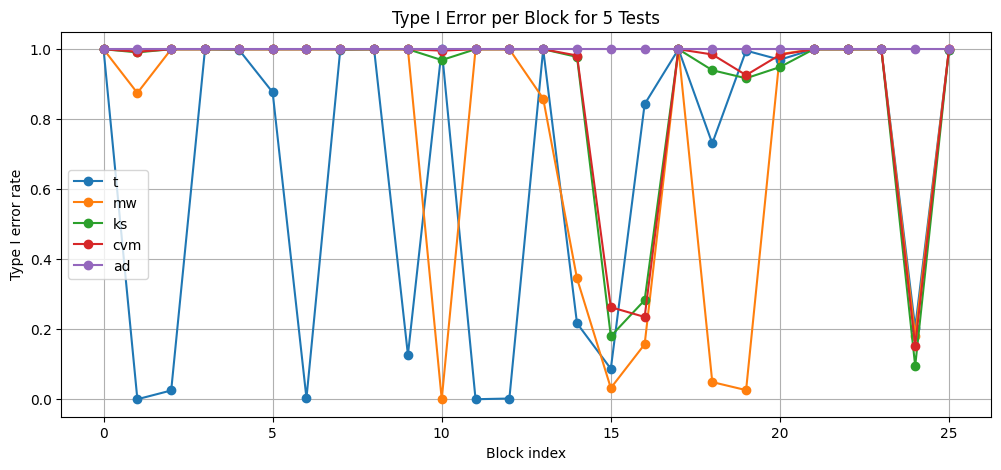

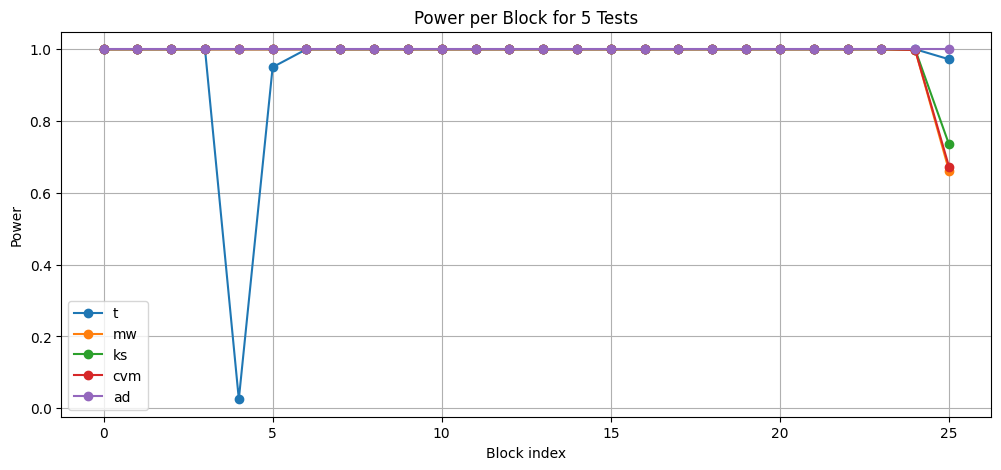

In [36]:
import matplotlib.pyplot as plt

# ----- 平均值計算 -----
avg_type1 = {t: df_type1[t].mean() for t in TESTS}
avg_power = {t: df_power[t].mean() for t in TESTS}

print("=== 平均 Type I error ===")
for t, v in avg_type1.items():
    print(f"{t}: {v:.3f}")
print("\n=== 平均 Power ===")
for t, v in avg_power.items():
    print(f"{t}: {v:.3f}")

# ----- 繪圖 -----
plt.figure(figsize=(12, 5))
for t in TESTS:
    plt.plot(df_type1["block"], df_type1[t], marker="o", label=t)
plt.xlabel("Block index")
plt.ylabel("Type I error rate")
plt.title("Type I Error per Block for 5 Tests")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
for t in TESTS:
    plt.plot(df_power["block"], df_power[t], marker="o", label=t)
plt.xlabel("Block index")
plt.ylabel("Power")
plt.title("Power per Block for 5 Tests")
plt.legend()
plt.grid(True)
plt.show()


[OK] 已輸出：orig_same_diff_examples_no_clamp.png


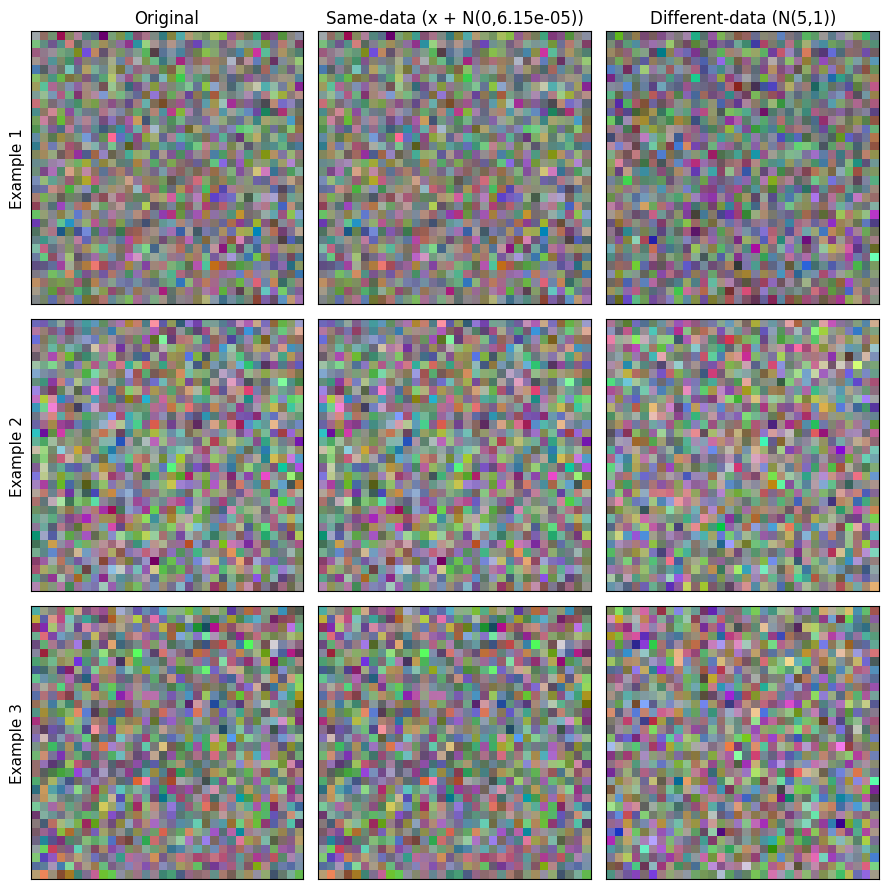

In [29]:
def to_disp_rescale(img):
    arr = img.squeeze(0).permute(1,2,0).detach().cpu().numpy()
    arr = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)
    return np.clip(arr, 0, 1)

def make_triplet(device="cpu"):
    # 原圖：隨機張量
    x = torch.randn(*INPUT_SHAPE, device=device)

    # 相同資料：在同一張 x 上加弱高斯雜訊
    y_same = x + torch.randn_like(x) * NOISE_STD

    # 不同資料：同一張 x 加上 mean shift (不 clamp)
    # y_diff = x + mean_shift
    y_diff = torch.randn(*INPUT_SHAPE, device=device) + mean_shift

    return x, y_same, y_diff

def visualize_examples(n_examples=3, out_path="orig_same_diff_examples_no_clamp.png", device="cpu"):
    triples = [make_triplet(device) for _ in range(n_examples)]
    fig, axes = plt.subplots(nrows=n_examples, ncols=3, figsize=(9, 3*n_examples))
    titles = ["Original", f"Same-data (x + N(0,{NOISE_STD**2:.2e}))", f"Different-data (N(5,1))"]

    if n_examples == 1:
        axes = np.array([axes])

    for r, (x, y_same, y_diff) in enumerate(triples):
        for c, img in enumerate([x, y_same, y_diff]):
            ax = axes[r, c]
            ax.imshow(to_disp_rescale(img))
            ax.set_xticks([]); ax.set_yticks([])
            if r == 0:
                ax.set_title(titles[c], fontsize=12)
        axes[r, 0].set_ylabel(f"Example {r+1}", fontsize=11)

    plt.tight_layout()
    plt.savefig(out_path, dpi=160, bbox_inches="tight")
    print(f"[OK] 已輸出：{out_path}")

# 直接呼叫產生 3 個例子
visualize_examples(n_examples=3, out_path="orig_same_diff_examples_no_clamp.png", device=str(device))

/tmp/ipykernel_646207/1848011268.py:57: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad = anderson_ksamp([a, b])
/tmp/ipykernel_646207/1848011268.py:57: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad = anderson_ksamp([a, b])



=== Average rejection rate vs mean shift (μ) ===
   mean_shift         t        mw        ks       cvm   ad
0        0.00  0.658462  0.763077  0.887692  0.880000  1.0
1        0.25  0.701923  0.755769  0.884615  0.872692  1.0
2        0.50  0.738462  0.770769  0.900000  0.895385  1.0
3        1.00  0.818077  0.812692  0.954231  0.951923  1.0
4        2.00  0.889615  0.839231  0.955769  0.947308  1.0
5        3.00  0.925769  0.872692  0.955385  0.958846  1.0
6        5.00  0.959615  0.985000  0.986154  0.985385  1.0
7        7.00  0.946154  1.000000  1.000000  1.000000  1.0
8       10.00  0.982692  0.961923  1.000000  1.000000  1.0


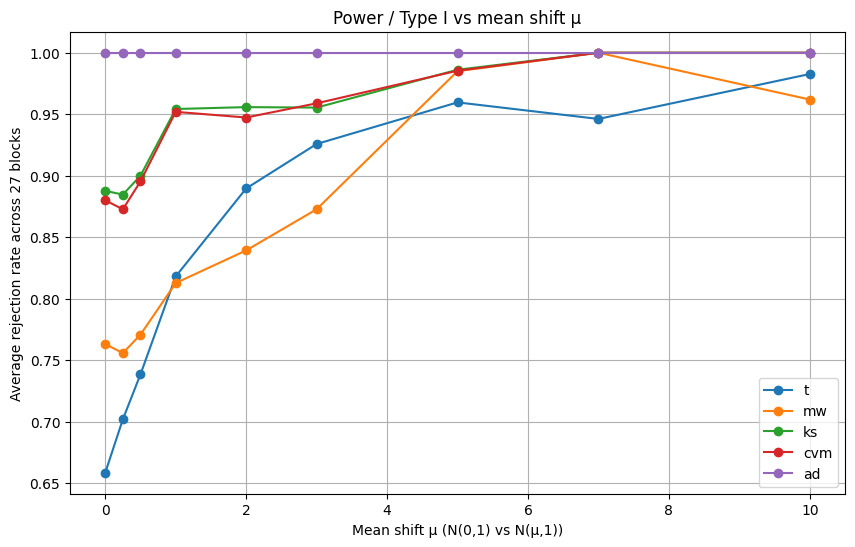

In [5]:
# ===== Power/Type-I vs mean shift =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch


TESTS = ["t", "mw", "ks", "cvm", "ad"]

def estimate_power_for_mean(mean_shift_value, B=1000, alpha=0.05):
    """
    對固定的 mean_shift_value，估計各檢定在 27 blocks 的平均拒絕率。
    mean_shift_value = 0 時相當於 H0（Type I error）；>0 時為 H1（Power）。
    回傳:
      avg_rates: dict[test] -> float (跨 27 blocks 平均)
      blockwise: dict[test] -> np.array shape (27,) (每個 block 的拒絕率)
    """
    reject_counts = {t: np.zeros(26, dtype=np.int32) for t in TESTS}

    for _ in range(B):
        x = torch.randn(*INPUT_SHAPE, device=device)
        y = torch.randn(*INPUT_SHAPE, device=device) + mean_shift_value

        acts_x = run_once(x)
        acts_y = run_once(y)

        for i in range(26):
            a = to_np(acts_x[i])
            b = to_np(acts_y[i+1])

            # t-test
            try:
                if ttest_ind(a, b, equal_var=False).pvalue < alpha:
                    reject_counts["t"][i] += 1
            except:
                pass
            # Mann-Whitney U
            try:
                if mannwhitneyu(a, b, alternative="two-sided").pvalue < alpha:
                    reject_counts["mw"][i] += 1
            except:
                pass
            # KS
            try:
                if ks_2samp(a, b).pvalue < alpha:
                    reject_counts["ks"][i] += 1
            except:
                pass
            # CvM
            try:
                if cramervonmises_2samp(a, b).pvalue < alpha:
                    reject_counts["cvm"][i] += 1
            except:
                pass
            # AD
            try:
                ad = anderson_ksamp([a, b])
                if (ad.significance_level / 100.0) < alpha:
                    reject_counts["ad"][i] += 1
            except:
                pass

    avg_rates = {}
    blockwise = {}
    for t in TESTS:
        block_power = reject_counts[t] / float(B)  # shape (27,)
        blockwise[t] = block_power
        avg_rates[t] = float(block_power.mean())
    return avg_rates, blockwise

# 你要掃的 mean shift 清單（可自行增減/變細）
mean_list = [0.0, 0.25, 0.5, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0]
B_scan = 100
alpha_scan = 0.05

# 保存平均 &（可選）逐 block 的結果
curves_avg = {t: [] for t in TESTS}           # test -> list over mean_list
curves_block = {t: [] for t in TESTS}         # test -> list of arrays (27,) over mean_list

for mu in mean_list:
    avg_rates, blockwise = estimate_power_for_mean(mu, B=B_scan, alpha=alpha_scan)
    for t in TESTS:
        curves_avg[t].append(avg_rates[t])
        curves_block[t].append(blockwise[t])   # shape (27,)

# 產出 DataFrame：每列是一個 mean_shift，欄位是各檢定的平均拒絕率（跨 27 blocks）
df_power_vs_mean = pd.DataFrame({
    "mean_shift": mean_list,
    **{t: curves_avg[t] for t in TESTS}
})
print("\n=== Average rejection rate vs mean shift (μ) ===")
print(df_power_vs_mean)

# 畫 Power vs μ（μ=0 時即為 Type I error）
plt.figure(figsize=(10,6))
for t in TESTS:
    plt.plot(df_power_vs_mean["mean_shift"], df_power_vs_mean[t], marker="o", label=t)
plt.xlabel("Mean shift μ (N(0,1) vs N(μ,1))")
plt.ylabel("Average rejection rate across 27 blocks")
plt.title("Power / Type I vs mean shift μ")
plt.grid(True)
plt.legend()
plt.show()

# （可選）如果你想看某個檢定在每個 block 的曲線：
# 例如畫 KS 在 27 個 block 的 power vs μ：
# ks_block = np.stack(curves_block["ks"], axis=0)  # shape (len(mean_list), 27)
# for i in range(27):
#     plt.plot(mean_list, ks_block[:, i], alpha=0.3)
# plt.xlabel("μ"); plt.ylabel("KS power per block"); plt.title("KS per-block power vs μ"); plt.show()


 - 用 CIFAR-10 同 label vs 異 label 當作輸入

In [26]:
import torch
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu, ks_2samp, cramervonmises_2samp, anderson_ksamp
from tqdm import tqdm
from torchvision import datasets, transforms

# ===== 環境 =====
torch.manual_seed(0)
np.random.seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== 載入 CIFAR-10 =====
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)

# 建立每個 label 的索引
class_indices = {i: [] for i in range(10)}
for idx, (_, label) in enumerate(train_dataset):
    class_indices[label].append(idx)

# ===== 載入 ResNet56 =====
import os, sys
sys.path.append("/ssd5/Roy/pruning/pytorch_resnet_cifar10-master")  # <-- 改成你的
import resnet_cifar10

arch = "resnet56"
model = resnet_cifar10.__dict__[arch]()
ckpt_path = "/ssd5/Roy/pruning/pytorch_resnet_cifar10-master/pretrained_models/resnet56.th"  # <-- 改成你的
ckpt = torch.load(ckpt_path, map_location="cpu")
state_dict = {k.replace("module.", ""): v for k, v in ckpt["state_dict"].items()}
model.load_state_dict(state_dict)
model.to(device).eval()

# ===== 掛 27 個 BasicBlock hook =====
activations = [None] * 27
hooks = []
def make_hook(idx):
    def hook_fn(module, inp, out):
        activations[idx] = out.detach().cpu()
    return hook_fn

idx = 0
for stage_name in ["layer1", "layer2", "layer3"]:
    layer = getattr(model, stage_name)
    for block in layer:
        hooks.append(block.register_forward_hook(make_hook(idx)))
        idx += 1
assert idx == 27

def run_once(img_tensor):
    for i in range(27):
        activations[i] = None
    _ = model(img_tensor)
    return [a.clone() for a in activations]

def to_np(x: torch.Tensor):
    return x.detach().cpu().contiguous().float().view(-1).numpy()

# ===== 模擬參數 =====
B = 100
alpha = 0.05
TESTS = ["t", "mw", "ks", "cvm", "ad"]
results = {t: {i: [] for i in range(27)} for t in TESTS}

# ===== H0: 同 label =====
for _ in tqdm(range(B), desc="Type I Error (same label)"):
    label = np.random.choice(10)
    idxs = np.random.choice(class_indices[label], size=2, replace=False)
    img1 = train_dataset[idxs[0]][0].unsqueeze(0).to(device)
    img2 = train_dataset[idxs[1]][0].unsqueeze(0).to(device)

    acts_x = run_once(img1)
    acts_y = run_once(img2)

    for i in range(27):
        a = to_np(acts_x[i])
        b = to_np(acts_y[i])
        try: results["t"][i].append(ttest_ind(a, b, equal_var=False).pvalue < alpha)
        except: results["t"][i].append(False)
        try: results["mw"][i].append(mannwhitneyu(a, b, alternative="two-sided").pvalue < alpha)
        except: results["mw"][i].append(False)
        try: results["ks"][i].append(ks_2samp(a, b).pvalue < alpha)
        except: results["ks"][i].append(False)
        try: results["cvm"][i].append(cramervonmises_2samp(a, b).pvalue < alpha)
        except: results["cvm"][i].append(False)
        try:
            ad = anderson_ksamp([a, b])
            results["ad"][i].append((ad.significance_level / 100.0) < alpha)
        except:
            results["ad"][i].append(False)

# ===== H1: 異 label =====
for _ in tqdm(range(B), desc="Power (different label)"):
    label1, label2 = np.random.choice(10, size=2, replace=False)
    idx1 = np.random.choice(class_indices[label1])
    idx2 = np.random.choice(class_indices[label2])
    img1 = train_dataset[idx1][0].unsqueeze(0).to(device)
    img2 = train_dataset[idx2][0].unsqueeze(0).to(device)

    acts_x = run_once(img1)
    acts_y = run_once(img2)

    for i in range(27):
        a = to_np(acts_x[i])
        b = to_np(acts_y[i])
        try: results["t"][i].append(ttest_ind(a, b, equal_var=False).pvalue < alpha)
        except: results["t"][i].append(False)
        try: results["mw"][i].append(mannwhitneyu(a, b, alternative="two-sided").pvalue < alpha)
        except: results["mw"][i].append(False)
        try: results["ks"][i].append(ks_2samp(a, b).pvalue < alpha)
        except: results["ks"][i].append(False)
        try: results["cvm"][i].append(cramervonmises_2samp(a, b).pvalue < alpha)
        except: results["cvm"][i].append(False)
        try:
            ad = anderson_ksamp([a, b])
            results["ad"][i].append((ad.significance_level / 100.0) < alpha)
        except:
            results["ad"][i].append(False)

# ===== 輸出結果 =====
import pandas as pd
df_type1 = pd.DataFrame({"block": list(range(27)), **{t: [sum(results[t][i][:B]) / B for i in range(27)] for t in TESTS}})
df_power = pd.DataFrame({"block": list(range(27)), **{t: [sum(results[t][i][B:]) / B for i in range(27)] for t in TESTS}})


Type I Error (same label):   0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_2540472/3737928031.py:90: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad = anderson_ksamp([a, b])
/tmp/ipykernel_2540472/3737928031.py:90: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad = anderson_ksamp([a, b])
Power (different label):   0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_2540472/3737928031.py:118: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad = anderson_ksamp([a, b])
Power (different label):   1%|          | 1/100 [00:00<00:35,  2.79it/s]/tmp/ipykernel_2540472/3737928031.py:118: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad = anderson_

In [27]:
print("=== Type I Error ===")
df_type1

=== Type I Error ===


,block,t,mw,ks,cvm,ad
0,0,0.43,0.59,0.99,0.99,1.0
1,1,0.57,0.61,0.99,0.98,1.0
2,2,0.60,0.63,0.99,0.97,1.0
3,3,0.64,0.64,0.99,0.99,1.0
4,4,0.63,0.61,0.98,0.96,1.0
5,5,0.62,0.64,0.98,0.96,1.0
6,6,0.61,0.65,0.99,0.97,1.0
7,7,0.64,0.64,0.99,0.99,1.0
8,8,0.62,0.61,1.00,1.00,1.0
9,9,0.33,0.40,0.76,0.65,1.0


In [28]:
print("\n=== Power ===")
df_power


=== Power ===


,block,t,mw,ks,cvm,ad
0,0,0.44,0.56,1.00,1.00,1.0
1,1,0.63,0.57,0.99,0.97,1.0
2,2,0.59,0.68,1.00,0.98,1.0
3,3,0.65,0.67,1.00,1.00,1.0
4,4,0.64,0.65,1.00,1.00,1.0
5,5,0.66,0.62,0.99,0.96,1.0
6,6,0.66,0.67,0.99,0.98,1.0
7,7,0.67,0.68,1.00,1.00,1.0
8,8,0.64,0.58,0.99,0.99,1.0
9,9,0.39,0.52,0.80,0.75,1.0


=== 平均 Type I error ===
t: 0.525
mw: 0.593
ks: 0.806
cvm: 0.809
ad: 1.000

=== 平均 Power ===
t: 0.576
mw: 0.591
ks: 0.830
cvm: 0.828
ad: 1.000


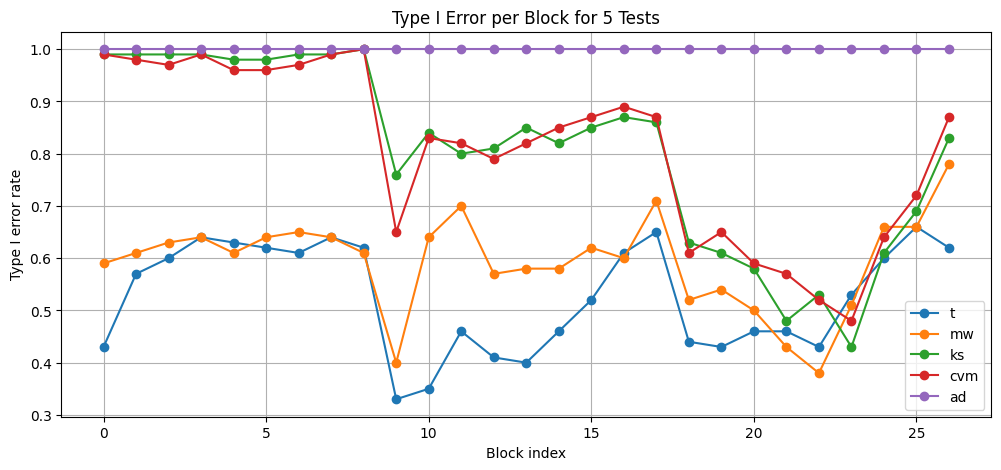

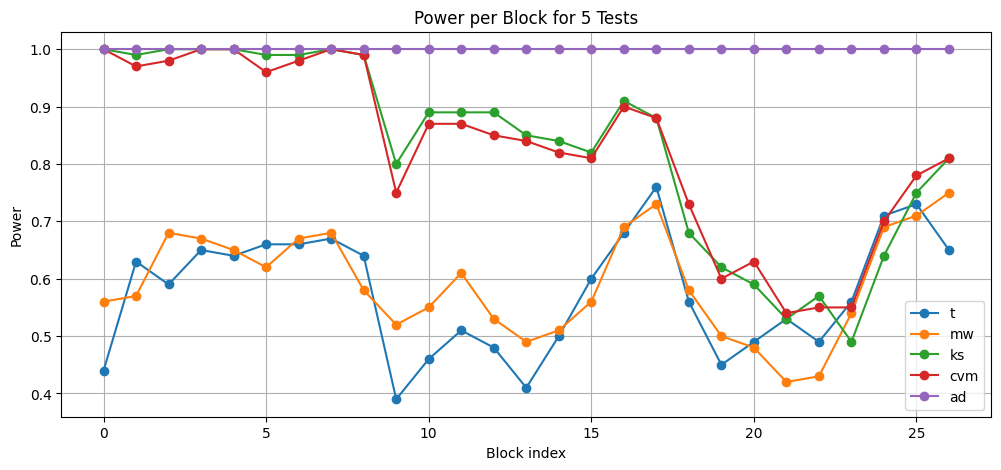

In [29]:
import matplotlib.pyplot as plt

# ----- 平均值計算 -----
avg_type1 = {t: df_type1[t].mean() for t in TESTS}
avg_power = {t: df_power[t].mean() for t in TESTS}

print("=== 平均 Type I error ===")
for t, v in avg_type1.items():
    print(f"{t}: {v:.3f}")
print("\n=== 平均 Power ===")
for t, v in avg_power.items():
    print(f"{t}: {v:.3f}")

# ----- 繪圖 -----
plt.figure(figsize=(12, 5))
for t in TESTS:
    plt.plot(df_type1["block"], df_type1[t], marker="o", label=t)
plt.xlabel("Block index")
plt.ylabel("Type I error rate")
plt.title("Type I Error per Block for 5 Tests")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
for t in TESTS:
    plt.plot(df_power["block"], df_power[t], marker="o", label=t)
plt.xlabel("Block index")
plt.ylabel("Power")
plt.title("Power per Block for 5 Tests")
plt.legend()
plt.grid(True)
plt.show()


 - 對同張照片做弱處理和強處理當作H0／H1成立

- - input1_i v.s. input2_i

In [ ]:
# ===== Route A: Same-image weak vs strong perturbations for H0/H1 =====
import os, sys, math
import torch
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu, ks_2samp, cramervonmises_2samp, anderson_ksamp

# ---------------- Config ----------------
DEVICE = torch.device("cpu")  # or "cuda" if you want
B = 100                       # repeats per hypothesis
ALPHA = 0.05
INPUT_SHAPE = (1, 3, 32, 32)

# Use CIFAR-10 as base images? (requires torchvision). If False, uses random images.
USE_CIFAR10 = True

# Your resnet_cifar10 repo + checkpoint paths
RESNET_REPO_DIR = "/ssd5/Roy/pruning/pytorch_resnet_cifar10-master"  # <-- change me
CKPT_PATH       = "/ssd5/Roy/pruning/pytorch_resnet_cifar10-master/pretrained_models/resnet56.th"  # <-- change me

# Weak/Strong perturbation strengths (tune to calibrate Type I ~ alpha, Power high)
WEAK_NOISE_STD   = 2/255
WEAK_SHIFT_PX    = 1          # ±1 pixel
WEAK_GAMMA_RANGE = (0.98, 1.02)
WEAK_CONTRAST    = (0.98, 1.02)

STRONG_BLUR_SIGMA  = 1.0      # Gaussian blur sigma
STRONG_GAMMA_RANGE = (0.7, 1.3)
STRONG_CONTRAST    = (0.85, 1.15)
STRONG_DOWNSAMPLE  = 2        # downsample x2 then upsample back

# =========================================================
# Utilities: tiny ops implemented in pure PyTorch
# =========================================================

def rand_uniform(a, b, shape=()):
    return (a + (b - a) * torch.rand(shape, device=x.device if (x:=torch.empty(0)) is not None else "cpu"))

def clamp_img(x):
    return x.clamp(-1, 1)

def add_gaussian_noise(x, std):
    return clamp_img(x + torch.randn_like(x) * std)

def gamma_adjust(x, gamma):
    # x in [-1,1] -> [0,1] -> gamma -> back to [-1,1]
    y = (x + 1) / 2
    y = torch.clamp(y, 0, 1)
    y = torch.pow(y, gamma)
    return clamp_img(y * 2 - 1)

def contrast_adjust(x, scale):
    # center at 0
    return clamp_img(x * scale)

def translate_xy(x, dx, dy):
    # dx, dy in pixels (integers small). pad & crop to simulate shift
    b, c, h, w = x.shape
    pad = max(abs(dx), abs(dy))
    if pad == 0:
        return x
    xp = torch.nn.functional.pad(x, (pad, pad, pad, pad), mode="replicate")
    x1 = pad + dy
    y1 = pad + dx
    return xp[:, :, x1:x1+h, y1:y1+w]

def gaussian_kernel2d(ksize=5, sigma=1.0, device="cpu"):
    ax = torch.arange(ksize, device=device) - (ksize - 1)/2
    xx, yy = torch.meshgrid(ax, ax, indexing="ij")
    k = torch.exp(-(xx**2 + yy**2) / (2*sigma*sigma))
    k = k / k.sum()
    return k

def gaussian_blur(x, sigma=1.0, ksize=5):
    if sigma <= 0:
        return x
    k = gaussian_kernel2d(ksize=ksize, sigma=sigma, device=x.device)
    k = k.view(1,1,ksize,ksize)
    c = x.shape[1]
    k = k.expand(c,1,ksize,ksize)
    return torch.nn.functional.conv2d(x, k, padding=ksize//2, groups=c)

def down_up_sample(x, factor=2):
    if factor <= 1:
        return x
    b, c, h, w = x.shape
    x_small = torch.nn.functional.interpolate(x, size=(h//factor, w//factor), mode="bilinear", align_corners=False)
    x_back  = torch.nn.functional.interpolate(x_small, size=(h, w), mode="bilinear", align_corners=False)
    return x_back

# =========================================================
# Weak / Strong augmentations (Route A)
# =========================================================
def weak_augs(x):
    # independent small jitter per call
    x2 = add_gaussian_noise(x, WEAK_NOISE_STD)
    dx = np.random.randint(-WEAK_SHIFT_PX, WEAK_SHIFT_PX+1)
    dy = np.random.randint(-WEAK_SHIFT_PX, WEAK_SHIFT_PX+1)
    x2 = translate_xy(x2, dx, dy)
    gamma = np.random.uniform(*WEAK_GAMMA_RANGE)
    x2 = gamma_adjust(x2, gamma)
    cscale = np.random.uniform(*WEAK_CONTRAST)
    x2 = contrast_adjust(x2, cscale)
    return x2

def strong_augs(x):
    x2 = gaussian_blur(x, sigma=STRONG_BLUR_SIGMA, ksize=5)
    gamma = np.random.uniform(*STRONG_GAMMA_RANGE)
    x2 = gamma_adjust(x2, gamma)
    cscale = np.random.uniform(*STRONG_CONTRAST)
    x2 = contrast_adjust(x2, cscale)
    x2 = down_up_sample(x2, factor=STRONG_DOWNSAMPLE)
    return x2

# =========================================================
# Base image provider (CIFAR-10 if available, else random)
# =========================================================
def prepare_cifar10_loader():
    try:
        from torchvision import datasets, transforms
        tfm = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
        ])
        ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=tfm)
        return ds
    except Exception as e:
        print("[INFO] torchvision/dataset unavailable, will use random images. Error:", e)
        return None

CIFAR_DS = prepare_cifar10_loader() if USE_CIFAR10 else None

def sample_base_image():
    if CIFAR_DS is not None:
        idx = np.random.randint(len(CIFAR_DS))
        img = CIFAR_DS[idx][0].unsqueeze(0).to(DEVICE)  # (1,3,32,32), normalized ~[-1,1]
    else:
        img = torch.randn(*INPUT_SHAPE, device=DEVICE)  # fallback random base
        img = img.clamp(-1, 1)
    return img

# =========================================================
# Load your CIFAR-ResNet56 and hook 27 BasicBlocks
# =========================================================
torch.manual_seed(0); np.random.seed(0)

sys.path.append(RESNET_REPO_DIR)
import resnet_cifar10

model = resnet_cifar10.resnet56()
ckpt = torch.load(CKPT_PATH, map_location="cpu")
state_dict = {k.replace("module.", ""): v for k, v in ckpt["state_dict"].items()}
model.load_state_dict(state_dict)
model.to(DEVICE).eval()

activations = [None] * 27
hooks = []

def make_hook(idx):
    def hook_fn(m, inp, out):
        activations[idx] = out.detach().cpu()
    return hook_fn

idx = 0
for stage_name in ["layer1", "layer2", "layer3"]:
    layer = getattr(model, stage_name)
    for block in layer:  # 9 blocks per layer => 27 total
        hooks.append(block.register_forward_hook(make_hook(idx)))
        idx += 1
assert idx == 27, f"Expect 27 hooks, got {idx}"

def run_once(x):
    for i in range(27):
        activations[i] = None
    _ = model(x)
    # sanity
    for i, a in enumerate(activations):
        if a is None:
            raise RuntimeError(f"Activation {i} is None")
    return [a.clone() for a in activations]

def to_np(x: torch.Tensor):
    return x.detach().cpu().contiguous().float().view(-1).numpy()

# =========================================================
# Main experiment (H0 via weak vs weak; H1 via weak vs strong)
# =========================================================
TESTS = ["t", "mw", "ks", "cvm", "ad"]
results = {t: {i: [] for i in range(27)} for t in TESTS}

# H0: same image, two weak augmentations
for _ in range(B):
    base = sample_base_image()
    x = weak_augs(base)
    y = weak_augs(base)

    acts_x = run_once(x)
    acts_y = run_once(y)

    for i in range(27):
        a = to_np(acts_x[i])
        b = to_np(acts_y[i])
        # t
        try: results["t"][i].append(ttest_ind(a, b, equal_var=False).pvalue < ALPHA)
        except: results["t"][i].append(False)
        # MW
        try: results["mw"][i].append(mannwhitneyu(a, b, alternative="two-sided").pvalue < ALPHA)
        except: results["mw"][i].append(False)
        # KS
        try: results["ks"][i].append(ks_2samp(a, b).pvalue < ALPHA)
        except: results["ks"][i].append(False)
        # CvM
        try: results["cvm"][i].append(cramervonmises_2samp(a, b).pvalue < ALPHA)
        except: results["cvm"][i].append(False)
        # AD
        try:
            ad = anderson_ksamp([a, b])
            results["ad"][i].append((ad.significance_level / 100.0) < ALPHA)
        except:
            results["ad"][i].append(False)

# H1: same image, weak vs strong augmentation
for _ in range(B):
    base = sample_base_image()
    x = weak_augs(base) 
    y = strong_augs(base)

    acts_x = run_once(x)
    acts_y = run_once(y)

    for i in range(27):
        a = to_np(acts_x[i])
        b = to_np(acts_y[i])
        # t
        try: results["t"][i].append(ttest_ind(a, b, equal_var=False).pvalue < ALPHA)
        except: results["t"][i].append(False)
        # MW
        try: results["mw"][i].append(mannwhitneyu(a, b, alternative="two-sided").pvalue < ALPHA)
        except: results["mw"][i].append(False)
        # KS
        try: results["ks"][i].append(ks_2samp(a, b).pvalue < ALPHA)
        except: results["ks"][i].append(False)
        # CvM
        try: results["cvm"][i].append(cramervonmises_2samp(a, b).pvalue < ALPHA)
        except: results["cvm"][i].append(False)
        # AD
        try:
            ad = anderson_ksamp([a, b])
            results["ad"][i].append((ad.significance_level / 100.0) < ALPHA)
        except:
            results["ad"][i].append(False)
            
# # Cleanup hooks
# for h in hooks:
#     h.remove()

/tmp/ipykernel_2540472/3727477777.py:215: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad = anderson_ksamp([a, b])
/tmp/ipykernel_2540472/3727477777.py:215: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad = anderson_ksamp([a, b])
/tmp/ipykernel_2540472/3727477777.py:246: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad = anderson_ksamp([a, b])


- - input1_i v.s. input2_i+1

In [1]:
# ===== Route A: Same-image weak vs strong perturbations for H0/H1 =====
import os, sys, math
import torch
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu, ks_2samp, cramervonmises_2samp, anderson_ksamp

# ---------------- Config ----------------
DEVICE = torch.device("cpu")  # or "cuda" if you want
B = 1000                       # repeats per hypothesis
ALPHA = 0.05
INPUT_SHAPE = (1, 3, 32, 32)

# Use CIFAR-10 as base images? (requires torchvision). If False, uses random images.
USE_CIFAR10 = True

# Your resnet_cifar10 repo + checkpoint paths
RESNET_REPO_DIR = "/ssd5/Roy/pruning/pytorch_resnet_cifar10-master"  # <-- change me
CKPT_PATH       = "/ssd5/Roy/pruning/pytorch_resnet_cifar10-master/pretrained_models/resnet56.th"  # <-- change me

# Weak/Strong perturbation strengths (tune to calibrate Type I ~ alpha, Power high)
WEAK_NOISE_STD   = 2/255
WEAK_SHIFT_PX    = 1          # ±1 pixel
WEAK_GAMMA_RANGE = (0.98, 1.02)
WEAK_CONTRAST    = (0.98, 1.02)

STRONG_BLUR_SIGMA  = 1.0      # Gaussian blur sigma
STRONG_GAMMA_RANGE = (0.7, 1.3)
STRONG_CONTRAST    = (0.85, 1.15)
STRONG_DOWNSAMPLE  = 2        # downsample x2 then upsample back

# =========================================================
# Utilities: tiny ops implemented in pure PyTorch
# =========================================================
def clamp_img(x):
    return x.clamp(-1, 1)

def rand_uniform(a, b, shape=()):
    return (a + (b - a) * torch.rand(shape, device=x.device if (x:=torch.empty(0)) is not None else "cpu"))

def add_gaussian_noise(x, std):
    return clamp_img(x + torch.randn_like(x) * std)

def gamma_adjust(x, gamma):
    # x in [-1,1] -> [0,1] -> gamma -> back to [-1,1]
    y = (x + 1) / 2
    y = torch.clamp(y, 0, 1)
    y = torch.pow(y, gamma)
    return clamp_img(y * 2 - 1)

def contrast_adjust(x, scale):
    # center at 0
    return clamp_img(x * scale)

def translate_xy(x, dx, dy):
    # dx, dy in pixels (integers small). pad & crop to simulate shift
    b, c, h, w = x.shape
    pad = max(abs(dx), abs(dy))
    if pad == 0:
        return x
    xp = torch.nn.functional.pad(x, (pad, pad, pad, pad), mode="replicate")
    x1 = pad + dy
    y1 = pad + dx
    return xp[:, :, x1:x1+h, y1:y1+w]

def gaussian_kernel2d(ksize=5, sigma=1.0, device="cpu"):
    ax = torch.arange(ksize, device=device) - (ksize - 1)/2
    xx, yy = torch.meshgrid(ax, ax, indexing="ij")
    k = torch.exp(-(xx**2 + yy**2) / (2*sigma*sigma))
    k = k / k.sum()
    return k

def gaussian_blur(x, sigma=1.0, ksize=5):
    if sigma <= 0:
        return x
    k = gaussian_kernel2d(ksize=ksize, sigma=sigma, device=x.device)
    k = k.view(1,1,ksize,ksize)
    c = x.shape[1]
    k = k.expand(c,1,ksize,ksize)
    return torch.nn.functional.conv2d(x, k, padding=ksize//2, groups=c)

def down_up_sample(x, factor=2):
    if factor <= 1:
        return x
    b, c, h, w = x.shape
    x_small = torch.nn.functional.interpolate(x, size=(h//factor, w//factor), mode="bilinear", align_corners=False)
    x_back  = torch.nn.functional.interpolate(x_small, size=(h, w), mode="bilinear", align_corners=False)
    return x_back

# =========================================================
# Weak / Strong augmentations (Route A)
# =========================================================
def weak_augs(x):
    # independent small jitter per call
    x2 = add_gaussian_noise(x, WEAK_NOISE_STD)
    # dx = np.random.randint(-WEAK_SHIFT_PX, WEAK_SHIFT_PX+1)
    # dy = np.random.randint(-WEAK_SHIFT_PX, WEAK_SHIFT_PX+1)
    # x2 = translate_xy(x2, dx, dy)
    # gamma = np.random.uniform(*WEAK_GAMMA_RANGE)
    # x2 = gamma_adjust(x2, gamma)
    # cscale = np.random.uniform(*WEAK_CONTRAST)
    # x2 = contrast_adjust(x2, cscale)
    return x2

def strong_augs(x):
    x2 = gaussian_blur(x, sigma=STRONG_BLUR_SIGMA, ksize=5)
    gamma = np.random.uniform(*STRONG_GAMMA_RANGE)
    x2 = gamma_adjust(x2, gamma)
    cscale = np.random.uniform(*STRONG_CONTRAST)
    x2 = contrast_adjust(x2, cscale)
    x2 = down_up_sample(x2, factor=STRONG_DOWNSAMPLE)
    return x2

# =========================================================
# Base image provider (CIFAR-10 if available, else random)
# =========================================================
def prepare_cifar10_loader():
    try:
        from torchvision import datasets, transforms
        tfm = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
        ])
        ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=tfm)
        return ds
    except Exception as e:
        print("[INFO] torchvision/dataset unavailable, will use random images. Error:", e)
        return None

CIFAR_DS = prepare_cifar10_loader() if USE_CIFAR10 else None

def sample_base_image():
    if CIFAR_DS is not None:
        idx = np.random.randint(len(CIFAR_DS))
        img = CIFAR_DS[idx][0].unsqueeze(0).to(DEVICE)  # (1,3,32,32), normalized ~[-1,1]
    else:
        img = torch.randn(*INPUT_SHAPE, device=DEVICE)  # fallback random base
        img = img.clamp(-1, 1)
    return img

# =========================================================
# Load your CIFAR-ResNet56 and hook 27 BasicBlocks
# =========================================================
torch.manual_seed(0); np.random.seed(0)

sys.path.append(RESNET_REPO_DIR)
import resnet_cifar10

model = resnet_cifar10.resnet56()
ckpt = torch.load(CKPT_PATH, map_location="cpu")
state_dict = {k.replace("module.", ""): v for k, v in ckpt["state_dict"].items()}
model.load_state_dict(state_dict)
model.to(DEVICE).eval()

activations = [None] * 27
hooks = []

def make_hook(idx):
    def hook_fn(m, inp, out):
        activations[idx] = out.detach().cpu()
    return hook_fn

idx = 0
for stage_name in ["layer1", "layer2", "layer3"]:
    layer = getattr(model, stage_name)
    for block in layer:  # 9 blocks per layer => 27 total
        hooks.append(block.register_forward_hook(make_hook(idx)))
        idx += 1
assert idx == 27, f"Expect 27 hooks, got {idx}"

def run_once(x):
    for i in range(27):
        activations[i] = None
    _ = model(x)
    # sanity
    for i, a in enumerate(activations):
        if a is None:
            raise RuntimeError(f"Activation {i} is None")
    return [a.clone() for a in activations]

def to_np(x: torch.Tensor):
    return x.detach().cpu().contiguous().float().view(-1).numpy()

# =========================================================
# Main experiment (H0 via weak vs weak; H1 via weak vs strong)
# =========================================================
TESTS = ["t", "mw", "ks", "cvm", "ad"]
results = {t: {i: [] for i in range(27)} for t in TESTS}

# H0: same image, two weak augmentations
for _ in range(B):
    base = sample_base_image()
    x = weak_augs(base)
    y = weak_augs(base)

    acts_x = run_once(x)
    acts_y = run_once(y)

    for i in range(26):
        a = to_np(acts_x[i])
        b = to_np(acts_y[i+1])
        # t
        try: results["t"][i].append(ttest_ind(a, b, equal_var=False).pvalue < ALPHA)
        except: results["t"][i].append(False)
        # MW
        try: results["mw"][i].append(mannwhitneyu(a, b, alternative="two-sided").pvalue < ALPHA)
        except: results["mw"][i].append(False)
        # KS
        try: results["ks"][i].append(ks_2samp(a, b).pvalue < ALPHA)
        except: results["ks"][i].append(False)
        # CvM
        try: results["cvm"][i].append(cramervonmises_2samp(a, b).pvalue < ALPHA)
        except: results["cvm"][i].append(False)
        # AD
        try:
            ad = anderson_ksamp([a, b])
            results["ad"][i].append((ad.significance_level / 100.0) < ALPHA)
        except:
            results["ad"][i].append(False)

# H1: same image, weak vs strong augmentation
for _ in range(B):
    base = sample_base_image()
    x = weak_augs(base) 
    y = strong_augs(base)

    acts_x = run_once(x)
    acts_y = run_once(y)

    for i in range(26):
        a = to_np(acts_x[i])
        b = to_np(acts_y[i+1])
        # t
        try: results["t"][i].append(ttest_ind(a, b, equal_var=False).pvalue < ALPHA)
        except: results["t"][i].append(False)
        # MW
        try: results["mw"][i].append(mannwhitneyu(a, b, alternative="two-sided").pvalue < ALPHA)
        except: results["mw"][i].append(False)
        # KS
        try: results["ks"][i].append(ks_2samp(a, b).pvalue < ALPHA)
        except: results["ks"][i].append(False)
        # CvM
        try: results["cvm"][i].append(cramervonmises_2samp(a, b).pvalue < ALPHA)
        except: results["cvm"][i].append(False)
        # AD
        try:
            ad = anderson_ksamp([a, b])
            results["ad"][i].append((ad.significance_level / 100.0) < ALPHA)
        except:
            results["ad"][i].append(False)
            
# # Cleanup hooks
# for h in hooks:
#     h.remove()

/tmp/ipykernel_646207/783635960.py:215: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad = anderson_ksamp([a, b])
/tmp/ipykernel_646207/783635960.py:215: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad = anderson_ksamp([a, b])
/tmp/ipykernel_646207/783635960.py:246: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad = anderson_ksamp([a, b])
/tmp/ipykernel_646207/783635960.py:246: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad = anderson_ksamp([a, b])


In [9]:
# ===== Route A: Same-image weak vs strong perturbations with full reproducibility =====
import os, sys, math, random
import torch
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu, ks_2samp, cramervonmises_2samp, anderson_ksamp
import torch.nn.functional as F

# ---------------- Config ----------------
DEVICE = torch.device("cpu")  # or "cuda"
B = 1000                     # repeats per hypothesis
ALPHA = 0.05
INPUT_SHAPE = (1, 3, 32, 32)

USE_CIFAR10 = True  # 若 False，改用隨機影像（也會可重現）

# Your resnet_cifar10 repo + checkpoint paths (請修改)
RESNET_REPO_DIR = "/ssd5/Roy/pruning/pytorch_resnet_cifar10-master"
CKPT_PATH       = "/ssd5/Roy/pruning/pytorch_resnet_cifar10-master/pretrained_models/resnet56.th"

# Weak/Strong perturbation strengths
WEAK_NOISE_STD   = 2/255
# (如需更多弱處理，請在 weak_augs 內補上並改用 np_rng/t_gen 取隨機參數)

STRONG_BLUR_SIGMA  = 1.0
STRONG_GAMMA_RANGE = (0.7, 1.3)
STRONG_CONTRAST    = (0.85, 1.15)
STRONG_DOWNSAMPLE  = 2

# 比較同層(i vs i)或跨層(i vs i+1)
SAME_LAYER_COMPARE = False

# ---------------- Reproducibility setup ----------------
BASE_SEED = 1337
torch.manual_seed(BASE_SEED)
np.random.seed(BASE_SEED)
random.seed(BASE_SEED)

# 如用 CUDA，建議啟用下面三行（CPU 可忽略）
# torch.use_deterministic_algorithms(True)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

# 全域的參考亂數器（保留，但所有 trial 都會使用各自的 rng/gen）
np_rng_global = np.random.RandomState(BASE_SEED)
torch_gen_global = torch.Generator(device=DEVICE).manual_seed(BASE_SEED)

# =========================================================
# Utilities
# =========================================================
def clamp_img(x):
    return x.clamp(-1, 1)

def add_gaussian_noise(x, std, torch_gen=None):
    # 在較舊的 PyTorch 版本，randn_like 不支援 generator
    if torch_gen is None:
        noise = torch.randn(x.shape, device=x.device, dtype=x.dtype)
    else:
        noise = torch.randn(x.shape, device=x.device, dtype=x.dtype, generator=torch_gen)
    return clamp_img(x + noise * std)

def gamma_adjust(x, gamma):
    # x in [-1,1] -> [0,1] -> gamma -> back to [-1,1]
    y = (x + 1) / 2
    y = torch.clamp(y, 0, 1)
    y = torch.pow(y, gamma)
    return clamp_img(y * 2 - 1)

def contrast_adjust(x, scale):
    return clamp_img(x * scale)

def gaussian_kernel2d(ksize=5, sigma=1.0, device="cpu"):
    ax = torch.arange(ksize, device=device) - (ksize - 1)/2
    xx, yy = torch.meshgrid(ax, ax, indexing="ij")
    k = torch.exp(-(xx**2 + yy**2) / (2*sigma*sigma))
    k = k / k.sum()
    return k

def gaussian_blur(x, sigma=1.0, ksize=5):
    if sigma <= 0:
        return x
    k = gaussian_kernel2d(ksize=ksize, sigma=sigma, device=x.device)
    k = k.view(1,1,ksize,ksize)
    c = x.shape[1]
    k = k.expand(c,1,ksize,ksize)
    return torch.nn.functional.conv2d(x, k, padding=ksize//2, groups=c)

def down_up_sample(x, factor=2):
    if factor <= 1:
        return x
    b, c, h, w = x.shape
    x_small = torch.nn.functional.interpolate(x, size=(h//factor, w//factor),
                                              mode="bilinear", align_corners=False)
    x_back  = torch.nn.functional.interpolate(x_small, size=(h, w),
                                              mode="bilinear", align_corners=False)
    return x_back

def mean_shift(x, shift=0.06, per_channel=True):
    """
    x: tensor in [-1, 1], shape (B, C, H, W)
    shift: 固定的偏移量 (建議小於 0.1)
    per_channel: True=每個通道各自 +shift；False=所有通道同一個 shift
    """
    if per_channel:
        delta = torch.full((x.shape[0], x.shape[1], 1, 1), shift, device=x.device)
    else:
        delta = torch.full((x.shape[0], 1, 1, 1), shift, device=x.device)

    y = x + delta
    # 用 soft clip 避免洗白 (比硬 clamp 好)
    return torch.tanh(y / 1.3)  # tau=1.3 可調

def center_crop_resize(x, scale=0.9):
    """
    x: (B, C, H, W), 值域[-1,1]
    scale: 裁切比例 (0<scale<=1)，例如 0.9 表示保留 90% 視野
    """
    assert 0 < scale <= 1.0
    b, c, h, w = x.shape
    new_h = max(1, int(round(h * scale)))
    new_w = max(1, int(round(w * scale)))
    top  = (h - new_h) // 2
    left = (w - new_w) // 2
    patch = x[:, :, top:top+new_h, left:left+new_w]
    out = F.interpolate(patch, size=(h, w), mode="bilinear", align_corners=False)
    return out

def color_per_channel_scale(x, scales=(1.02, 0.98, 1.00), use_softclip=True):
    # 對 R/G/B 分別做固定倍率（非隨機），改變色彩比例
    b, c, h, w = x.shape
    s = torch.tensor(scales, device=x.device, dtype=x.dtype).view(1, c, 1, 1)
    y = x * s
    return torch.tanh(y / 1.3) if use_softclip else y.clamp(-1, 1)


# =========================================================
# Weak / Strong augmentations (Route A) — 全部用專屬 rng/gen
# =========================================================
def weak_augs(x, np_rng=None, torch_gen=None):
    # 目前弱處理只有極小高斯雜訊；若你要加平移/gamma/對比度，
    # 也請用 np_rng 產生參數、用 torch_gen 產生雜訊。
    x2 = add_gaussian_noise(x, WEAK_NOISE_STD, torch_gen=torch_gen)
    return x2

def strong_augs(x, np_rng=None, torch_gen=None):
    # 0) 可選：固定 Gaussian blur（不要用隨機 sigma）
    x2 = gaussian_blur(x, sigma=STRONG_BLUR_SIGMA, ksize=5)

    # 1) 固定中心裁切 + 放回原尺寸（無隨機）
    x2 = center_crop_resize(x, scale=0.8)  # 固定視野比例   

    # # 2) 固定色彩比例（改變 R/G/B 的相對比例）
    x2 = color_per_channel_scale(
        x2,
        scales=(1.2, 0.8, 1.0),  # R +2%, G -2%, B 不變
        use_softclip=True
    )

    # if np_rng is None:
    #     gamma = np.random.uniform(*STRONG_GAMMA_RANGE)
    #     cscale = np.random.uniform(*STRONG_CONTRAST)
    # else:
    #     gamma = np_rng.uniform(*STRONG_GAMMA_RANGE)
    #     cscale = np_rng.uniform(*STRONG_CONTRAST)
    # # 3) 固定 gamma（亮度曲線）
    # x2 = gamma_adjust(x2, gamma)
    # # 4) 固定對比
    # x2 = contrast_adjust(x2, cscale)

    # x2 = down_up_sample(x2, factor=STRONG_DOWNSAMPLE)

    # # ✅ 固定 mean shift，所有圖片偏移相同
    # x2 = mean_shift(x2, shift=-1.0, per_channel=True) 

    return x2

# =========================================================
# Base image provider (CIFAR-10 if available, else random)
# =========================================================
def prepare_cifar10_loader():
    if not USE_CIFAR10:
        return None
    try:
        from torchvision import datasets, transforms
        tfm = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),  # -> roughly [-1,1]
        ])
        ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=tfm)
        return ds
    except Exception as e:
        print("[INFO] torchvision/dataset unavailable, will use random images. Error:", e)
        return None

CIFAR_DS = prepare_cifar10_loader()

def sample_base_image(index=None):
    if CIFAR_DS is not None:
        if index is None:
            idx = np_rng_global.randint(len(CIFAR_DS))
        else:
            idx = int(index)
        img = CIFAR_DS[idx][0].unsqueeze(0).to(DEVICE)  # (1,3,32,32)
    else:
        # 隨機影像也提供可重現性（用全域 gen；trial 內會覆寫）
        img = torch.randn(*INPUT_SHAPE, device=DEVICE, generator=torch_gen_global).clamp(-1, 1)
    return img

# =========================================================
# Load CIFAR-ResNet56 and hook 27 BasicBlocks
# =========================================================
torch.manual_seed(BASE_SEED); np.random.seed(BASE_SEED); random.seed(BASE_SEED)

sys.path.append(RESNET_REPO_DIR)
import resnet_cifar10

model = resnet_cifar10.resnet56()
ckpt = torch.load(CKPT_PATH, map_location="cpu")
state_dict = {k.replace("module.", ""): v for k, v in ckpt["state_dict"].items()}
model.load_state_dict(state_dict)
model.to(DEVICE).eval()

activations = [None] * 27
hooks = []

def make_hook(idx):
    def hook_fn(m, inp, out):
        activations[idx] = out.detach().cpu()
    return hook_fn

idx = 0
for stage_name in ["layer1", "layer2", "layer3"]:
    layer = getattr(model, stage_name)
    for block in layer:  # 9 blocks per layer => 27 total
        hooks.append(block.register_forward_hook(make_hook(idx)))
        idx += 1
assert idx == 27, f"Expect 27 hooks, got {idx}"

def run_once(x):
    for i in range(27):
        activations[i] = None
    _ = model(x)
    for i, a in enumerate(activations):
        if a is None:
            raise RuntimeError(f"Activation {i} is None")
    return [a.clone() for a in activations]

def to_np(x: torch.Tensor):
    return x.detach().cpu().contiguous().float().view(-1).numpy()

# =========================================================
# Pre-generate fixed indices & trial-specific seeds
# =========================================================
if CIFAR_DS is not None:
    N = len(CIFAR_DS)
    IDX_H0 = np_rng_global.randint(0, N, size=B)
    IDX_H1 = np_rng_global.randint(0, N, size=B)
else:
    IDX_H0 = None
    IDX_H1 = None

H0_SEEDS = []
H1_SEEDS = []
for t in range(B):
    H0_SEEDS.append({
        "np_x":  BASE_SEED + 10_000 + t*4 + 0,
        "np_y":  BASE_SEED + 10_000 + t*4 + 1,
        "th_x":  BASE_SEED + 20_000 + t*4 + 0,
        "th_y":  BASE_SEED + 20_000 + t*4 + 1,
    })
    H1_SEEDS.append({
        "np_w":  BASE_SEED + 30_000 + t*4 + 0,
        "np_s":  BASE_SEED + 30_000 + t*4 + 1,
        "th_w":  BASE_SEED + 40_000 + t*4 + 0,
        "th_s":  BASE_SEED + 40_000 + t*4 + 1,
    })

# =========================================================
# Main experiment (H0 via weak vs weak; H1 via weak vs strong)
# =========================================================
TESTS = ["t", "mw", "ks", "cvm", "ad"]
results_H0 = {t: {i: [] for i in range(27)} for t in TESTS}
results_H1 = {t: {i: [] for i in range(27)} for t in TESTS}

pair_next = (not SAME_LAYER_COMPARE)  # True => i vs i+1, False => i vs i
MAX_I = 26 if pair_next else 27       # 跨層只能到 0..25；同層可以 0..26

# -------- H0: same image, two weak augs --------
for t in range(B):
    base = sample_base_image(index=IDX_H0[t] if IDX_H0 is not None else None)

    np_rng_x = np.random.RandomState(H0_SEEDS[t]["np_x"])
    np_rng_y = np.random.RandomState(H0_SEEDS[t]["np_y"])
    th_gen_x = torch.Generator(device=DEVICE).manual_seed(H0_SEEDS[t]["th_x"])
    th_gen_y = torch.Generator(device=DEVICE).manual_seed(H0_SEEDS[t]["th_y"])

    x = weak_augs(base, np_rng=np_rng_x, torch_gen=th_gen_x)
    y = weak_augs(base, np_rng=np_rng_y, torch_gen=th_gen_y)

    acts_x = run_once(x)
    acts_y = run_once(y)

    for i in range(MAX_I if pair_next else MAX_I):
        j = i+1 if pair_next else i
        a = to_np(acts_x[i])
        b = to_np(acts_y[j])

        # t
        try: results_H0["t"][i].append(ttest_ind(a, b, equal_var=False).pvalue < ALPHA)
        except: results_H0["t"][i].append(False)
        # MW
        try: results_H0["mw"][i].append(mannwhitneyu(a, b, alternative="two-sided").pvalue < ALPHA)
        except: results_H0["mw"][i].append(False)
        # KS
        try: results_H0["ks"][i].append(ks_2samp(a, b).pvalue < ALPHA)
        except: results_H0["ks"][i].append(False)
        # CvM
        try: results_H0["cvm"][i].append(cramervonmises_2samp(a, b).pvalue < ALPHA)
        except: results_H0["cvm"][i].append(False)
        # AD (significance_level 是百分比)
        try:
            ad = anderson_ksamp([a, b])
            results_H0["ad"][i].append((ad.significance_level / 100.0) < ALPHA)
        except:
            results_H0["ad"][i].append(False)

# -------- H1: same image, weak vs strong --------
for t in range(B):
    base = sample_base_image(index=IDX_H1[t] if IDX_H1 is not None else None)

    np_rng_w = np.random.RandomState(H1_SEEDS[t]["np_w"])
    np_rng_s = np.random.RandomState(H1_SEEDS[t]["np_s"])
    th_gen_w = torch.Generator(device=DEVICE).manual_seed(H1_SEEDS[t]["th_w"])
    th_gen_s = torch.Generator(device=DEVICE).manual_seed(H1_SEEDS[t]["th_s"])

    x = weak_augs(base,   np_rng=np_rng_w, torch_gen=th_gen_w)
    y = strong_augs(base, np_rng=np_rng_s, torch_gen=th_gen_s)

    acts_x = run_once(x)
    acts_y = run_once(y)

    for i in range(MAX_I if pair_next else MAX_I):
        j = i+1 if pair_next else i
        a = to_np(acts_x[i])
        b = to_np(acts_y[j])

        # t
        try: results_H1["t"][i].append(ttest_ind(a, b, equal_var=False).pvalue < ALPHA)
        except: results_H1["t"][i].append(False)
        # MW
        try: results_H1["mw"][i].append(mannwhitneyu(a, b, alternative="two-sided").pvalue < ALPHA)
        except: results_H1["mw"][i].append(False)
        # KS
        try: results_H1["ks"][i].append(ks_2samp(a, b).pvalue < ALPHA)
        except: results_H1["ks"][i].append(False)
        # CvM
        try: results_H1["cvm"][i].append(cramervonmises_2samp(a, b).pvalue < ALPHA)
        except: results_H1["cvm"][i].append(False)
        # AD
        try:
            ad = anderson_ksamp([a, b])
            results_H1["ad"][i].append((ad.significance_level / 100.0) < ALPHA)
        except:
            results_H1["ad"][i].append(False)

# # Cleanup hooks (若需要解除)
# for h in hooks:
#     h.remove()

# =========================================================
# Simple summary: 型一錯誤(≈alpha) 與 檢定力
# =========================================================
def summarize(results_dict, name):
    print(f"\n===== {name} =====")
    for test in TESTS:
        vals = []
        for i in range(MAX_I if pair_next else MAX_I):
            arr = results_dict[test][i]
            if len(arr) > 0:
                vals.append(np.mean(arr))
        if len(vals) > 0:
            print(f"{test:>4s}  mean reject rate over blocks = {np.mean(vals):.4f}")

summarize(results_H0, "H0 (weak vs weak)  — expect ≈ alpha")
summarize(results_H1, "H1 (weak vs strong) — expect high power")
print("\nConfig:",
      f"SAME_LAYER_COMPARE={SAME_LAYER_COMPARE}, MAX_I={MAX_I}, B={B}, ALPHA={ALPHA}")


/tmp/ipykernel_75479/2834562444.py:321: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad = anderson_ksamp([a, b])
/tmp/ipykernel_75479/2834562444.py:321: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad = anderson_ksamp([a, b])
/tmp/ipykernel_75479/2834562444.py:360: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad = anderson_ksamp([a, b])
/tmp/ipykernel_75479/2834562444.py:360: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad = anderson_ksamp([a, b])



===== H0 (weak vs weak)  — expect ≈ alpha =====
   t  mean reject rate over blocks = 0.6833
  mw  mean reject rate over blocks = 0.8178
  ks  mean reject rate over blocks = 0.8678
 cvm  mean reject rate over blocks = 0.8601
  ad  mean reject rate over blocks = 1.0000

===== H1 (weak vs strong) — expect high power =====
   t  mean reject rate over blocks = 0.8508
  mw  mean reject rate over blocks = 0.8373
  ks  mean reject rate over blocks = 0.9656
 cvm  mean reject rate over blocks = 0.9627
  ad  mean reject rate over blocks = 1.0000

Config: SAME_LAYER_COMPARE=False, MAX_I=26, B=1000, ALPHA=0.05


In [13]:
rg = 26
# =========================================================
# Build df_type1 / df_power and summarize averages
# =========================================================
import pandas as pd
df_type1 = pd.DataFrame({
    "block": list(range(rg)),
    **{t: [sum(results_H0[t][i][:B]) / B for i in range(rg)] for t in TESTS}
})
print("=== Type I Error (H0: weak vs weak) ===")
df_type1

=== Type I Error (H0: weak vs weak) ===


,block,t,mw,ks,cvm,ad
0,0,1.000,1.000,1.000,1.000,1.0
1,1,1.000,1.000,1.000,1.000,1.0
2,2,1.000,1.000,1.000,1.000,1.0
3,3,1.000,1.000,1.000,1.000,1.0
4,4,1.000,1.000,1.000,1.000,1.0
5,5,1.000,1.000,1.000,1.000,1.0
6,6,1.000,1.000,1.000,1.000,1.0
7,7,0.999,0.949,0.994,0.998,1.0
8,8,1.000,1.000,1.000,1.000,1.0
9,9,0.820,1.000,1.000,1.000,1.0


In [14]:
df_power = pd.DataFrame({
    "block": list(range(rg)),
    **{t: [sum(results_H1[t][i][:B]) / B for i in range(rg)] for t in TESTS}
})
print("\n=== Power (H1: weak vs strong) ===")
df_power


=== Power (H1: weak vs strong) ===


,block,t,mw,ks,cvm,ad
0,0,0.999,0.996,1.000,1.000,1.0
1,1,1.000,1.000,1.000,1.000,1.0
2,2,1.000,1.000,1.000,1.000,1.0
3,3,1.000,1.000,1.000,1.000,1.0
4,4,1.000,1.000,1.000,1.000,1.0
5,5,1.000,1.000,1.000,1.000,1.0
6,6,1.000,1.000,1.000,1.000,1.0
7,7,0.976,0.961,1.000,1.000,1.0
8,8,1.000,1.000,1.000,1.000,1.0
9,9,0.184,0.971,1.000,1.000,1.0



=== Average Type I Error by test ===
t: 0.683
mw: 0.818
ks: 0.868
cvm: 0.860
ad: 1.000

=== Average Power by test ===
t: 0.851
mw: 0.837
ks: 0.966
cvm: 0.963
ad: 1.000


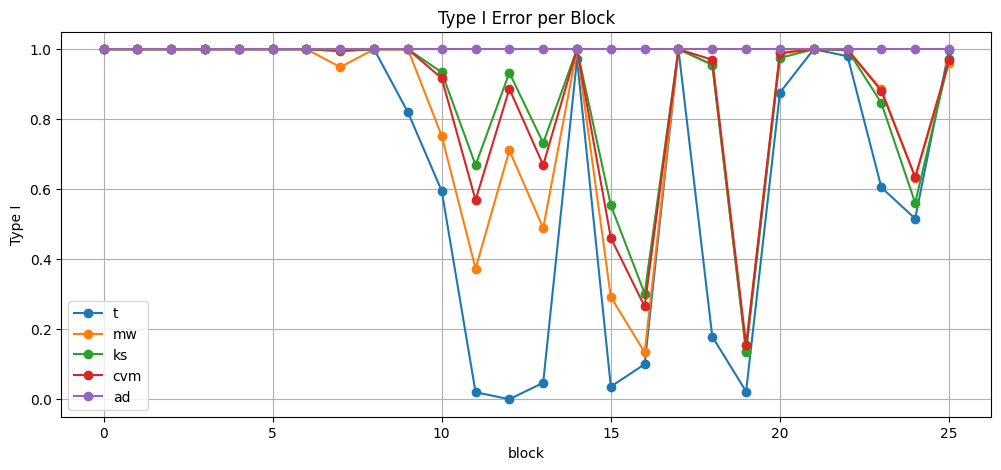

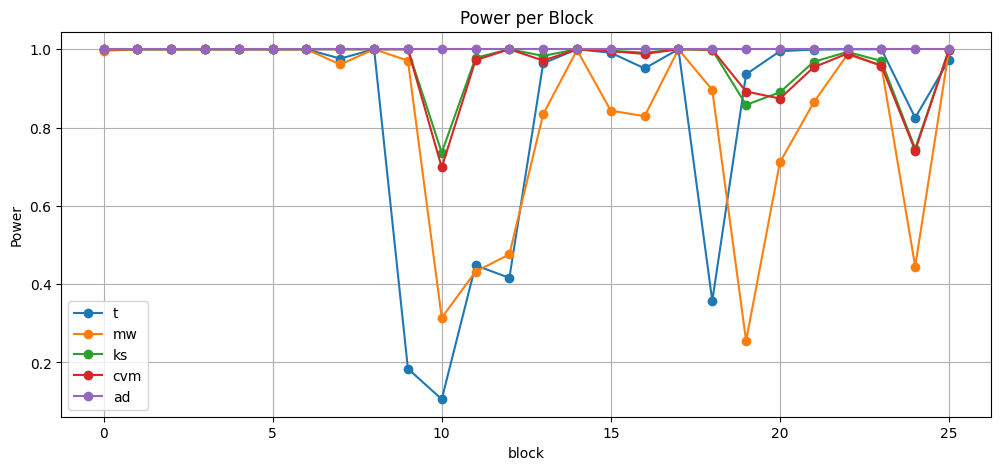

In [15]:

# Averages
avg_type1 = {t: df_type1[t].mean() for t in TESTS}
avg_power = {t: df_power[t].mean() for t in TESTS}
print("\n=== Average Type I Error by test ===")
for t,v in avg_type1.items(): print(f"{t}: {v:.3f}")
print("\n=== Average Power by test ===")
for t,v in avg_power.items(): print(f"{t}: {v:.3f}")


# Plots (optional)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
for t in TESTS: plt.plot(df_type1["block"], df_type1[t], marker="o", label=t)
plt.title("Type I Error per Block"); plt.xlabel("block"); plt.ylabel("Type I"); plt.legend(); plt.grid(True); plt.show()
plt.figure(figsize=(12,5))
for t in TESTS: plt.plot(df_power["block"], df_power[t], marker="o", label=t)
plt.title("Power per Block"); plt.xlabel("block"); plt.ylabel("Power"); plt.legend(); plt.grid(True); plt.show()

[OK] 已輸出：weak_vs_strong_examples.png


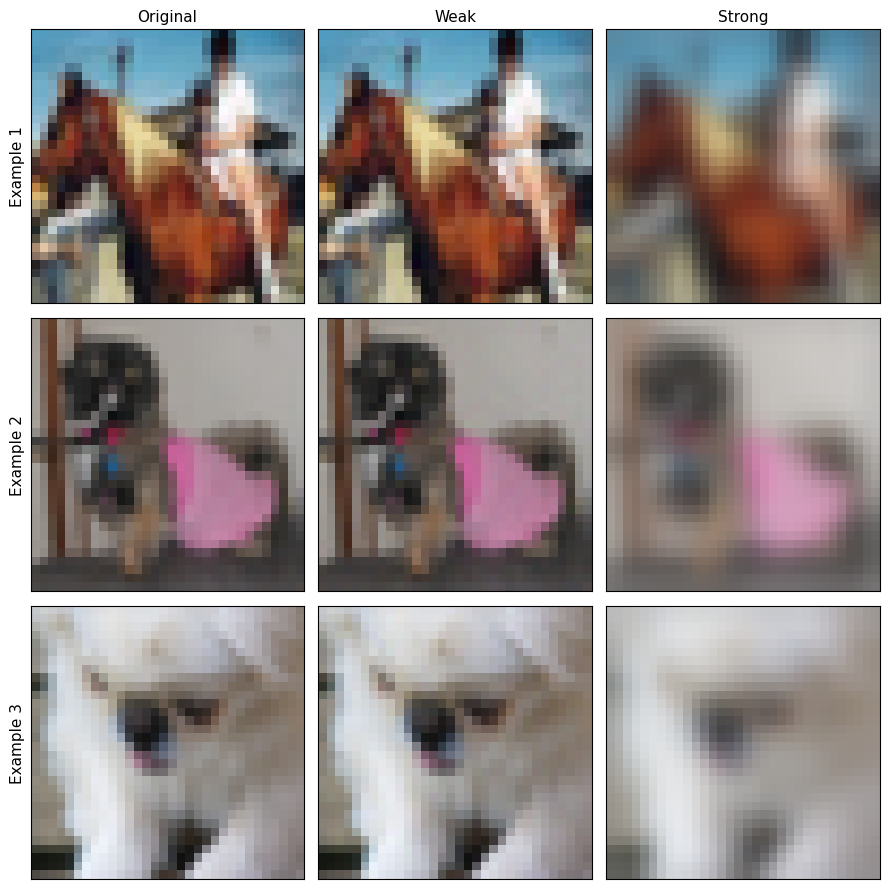

In [3]:
# === visualize_weak_vs_strong.py ===
# 作用：把輸入圖片各自做「弱處理、強處理」，存圖顯示差異（以你的增強定義為準）
import os, glob, math, numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

# ---------------- Config ----------------
DEVICE = "cpu"            # 或 "cuda"
OUT_PATH = "weak_vs_strong_examples.png"
NUM_EXAMPLES = 3          # 取幾張圖做示範
USE_CIFAR10 = True       # True 用 CIFAR-10；False 則用資料夾或隨機影像
IMG_DIR = "./images"      # 當 USE_CIFAR10=False 時，會嘗試從這個資料夾讀圖 (jpg/png)
INPUT_SHAPE = (1, 3, 32, 32)  # 若是隨機影像或資料夾匯入後的 resize 尺寸

# 你的弱/強處理參數（與你貼的設定一致）
WEAK_NOISE_STD   = 2/255
STRONG_BLUR_SIGMA  = 1.0
STRONG_GAMMA_RANGE = (0.7, 1.3)
STRONG_CONTRAST    = (0.85, 1.15)
STRONG_DOWNSAMPLE  = 2

torch.manual_seed(0); np.random.seed(0)

# ---------------- Utilities ----------------
def clamp_img(x): return x.clamp(-1, 1)

def add_gaussian_noise(x, std):
    return clamp_img(x + torch.randn_like(x) * std)

def gamma_adjust(x, gamma):
    # x: [-1,1] -> [0,1] -> gamma -> [-1,1]
    y = (x + 1) / 2
    y = torch.clamp(y, 0, 1)
    y = torch.pow(y, gamma)
    return clamp_img(y * 2 - 1)

def contrast_adjust(x, scale):
    return clamp_img(x * scale)

def gaussian_kernel2d(ksize=5, sigma=1.0, device="cpu"):
    ax = torch.arange(ksize, device=device) - (ksize - 1)/2
    xx, yy = torch.meshgrid(ax, ax, indexing="ij")
    k = torch.exp(-(xx**2 + yy**2) / (2*sigma*sigma))
    k = k / k.sum()
    return k

def gaussian_blur(x, sigma=1.0, ksize=5):
    if sigma <= 0: return x
    k = gaussian_kernel2d(ksize=ksize, sigma=sigma, device=x.device).view(1,1,ksize,ksize)
    c = x.shape[1]
    k = k.expand(c,1,ksize,ksize)
    return torch.nn.functional.conv2d(x, k, padding=ksize//2, groups=c)

def down_up_sample(x, factor=2):
    if factor <= 1: return x
    b, c, h, w = x.shape
    x_small = torch.nn.functional.interpolate(x, size=(h//factor, w//factor),
                                              mode="bilinear", align_corners=False)
    x_back  = torch.nn.functional.interpolate(x_small, size=(h, w),
                                              mode="bilinear", align_corners=False)
    return x_back

# ---- 你的增強定義（與你貼的相同語意）----
def weak_augs(x):
    # 你目前的程式只有加很小的 Gaussian 噪聲
    x2 = add_gaussian_noise(x, WEAK_NOISE_STD)
    return x2

def strong_augs(x):
    x2 = gaussian_blur(x, sigma=STRONG_BLUR_SIGMA, ksize=5)
    gamma = np.random.uniform(*STRONG_GAMMA_RANGE)
    x2 = gamma_adjust(x2, gamma)
    cscale = np.random.uniform(*STRONG_CONTRAST)
    x2 = contrast_adjust(x2, cscale)
    x2 = down_up_sample(x2, factor=STRONG_DOWNSAMPLE)
    return x2

# ---------------- Data providers ----------------
def load_cifar10_examples(n=3):
    from torchvision import datasets, transforms
    tfm = transforms.Compose([
        transforms.ToTensor(),                      # [0,1]
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) # -> [-1,1]
    ])
    ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=tfm)
    idxs = np.random.choice(len(ds), size=n, replace=False)
    imgs = [ds[int(i)][0].unsqueeze(0) for i in idxs]  # list of (1,3,32,32)
    return imgs

def load_from_folder_examples(img_dir, n=3, shape=(1,3,32,32)):
    paths = sorted(glob.glob(os.path.join(img_dir, "*.jpg")) + 
                   glob.glob(os.path.join(img_dir, "*.png")))
    if len(paths) == 0:
        print(f"[WARN] 資料夾 {img_dir} 沒找到圖片，改用隨機影像。")
        return make_random_examples(n, shape)
    picks = paths[:n] if len(paths) >= n else (paths + [paths[0]]*(n-len(paths)))
    imgs = []
    B, C, H, W = shape
    for p in picks:
        im = Image.open(p).convert("RGB").resize((W, H), Image.BILINEAR)
        arr = np.asarray(im).astype(np.float32) / 255.0          # [0,1]
        arr = arr.transpose(2,0,1)                               # C,H,W
        ten = torch.from_numpy(arr).unsqueeze(0)                 # 1,C,H,W
        ten = ten*2 - 1                                          # -> [-1,1]
        imgs.append(ten)
    return imgs

def make_random_examples(n=3, shape=(1,3,32,32)):
    imgs = []
    for _ in range(n):
        x = torch.randn(*shape)  # roughly N(0,1)
        x = x.clamp(-1, 1)
        imgs.append(x)
    return imgs

# ---------------- Visualization ----------------
def to_disp(img):  # (1,3,H,W) in [-1,1] -> (H,W,3) in [0,1]
    arr = img.squeeze(0).permute(1,2,0).detach().cpu().numpy()
    arr = (arr + 1)/2
    return np.clip(arr, 0, 1)

def visualize_triptychs(img_list, out_path=OUT_PATH, title_cols=("Original","Weak","Strong")):
    n = len(img_list)
    fig, axes = plt.subplots(nrows=n, ncols=3, figsize=(3*3, n*3))
    if n == 1:
        axes = np.array([axes])
    for r, base in enumerate(img_list):
        weak = weak_augs(base.clone().to(DEVICE))
        strong = strong_augs(base.clone().to(DEVICE))
        for c, img in enumerate([base, weak, strong]):
            ax = axes[r, c]
            ax.imshow(to_disp(img))
            ax.set_xticks([]); ax.set_yticks([])
            if r == 0: ax.set_title(title_cols[c], fontsize=11)
        axes[r,0].set_ylabel(f"Example {r+1}", fontsize=11)
    plt.tight_layout()
    plt.savefig(out_path, dpi=160, bbox_inches="tight")
    print(f"[OK] 已輸出：{out_path}")

# ---------------- Main ----------------
if __name__ == "__main__":
    if USE_CIFAR10:
        try:
            bases = load_cifar10_examples(NUM_EXAMPLES)
        except Exception as e:
            print("[INFO] CIFAR-10 失敗，改用資料夾/隨機：", e)
            bases = load_from_folder_examples(IMG_DIR, NUM_EXAMPLES, INPUT_SHAPE)
    else:
        # 先嘗試資料夾，再退回隨機影像
        bases = load_from_folder_examples(IMG_DIR, NUM_EXAMPLES, INPUT_SHAPE)

    visualize_triptychs(bases, OUT_PATH)

    # 若你已經有 Tensor (B,3,H,W) in [-1,1]，也可以這樣做：
    # your_batch: torch.Tensor = ...
    # bases = [your_batch[i:i+1] for i in range(min(NUM_EXAMPLES, your_batch.size(0)))]
    # visualize_triptychs(bases, "from_tensor_batch.png")


- - 改變 sigma

/tmp/ipykernel_646207/2298883054.py:52: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad = anderson_ksamp([a, b])
/tmp/ipykernel_646207/2298883054.py:52: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad = anderson_ksamp([a, b])


sigma=0.0: t=0.687 mw=0.815 ks=0.865 cvm=0.860 ad=1.000
sigma=0.25: t=0.680 mw=0.811 ks=0.862 cvm=0.855 ad=1.000
sigma=0.5: t=0.697 mw=0.794 ks=0.859 cvm=0.858 ad=1.000
sigma=0.75: t=0.818 mw=0.836 ks=0.950 cvm=0.946 ad=1.000
sigma=1.0: t=0.878 mw=0.867 ks=0.984 cvm=0.981 ad=1.000
sigma=1.25: t=0.909 mw=0.870 ks=0.990 cvm=0.987 ad=1.000
sigma=1.5: t=0.920 mw=0.873 ks=0.990 cvm=0.988 ad=1.000


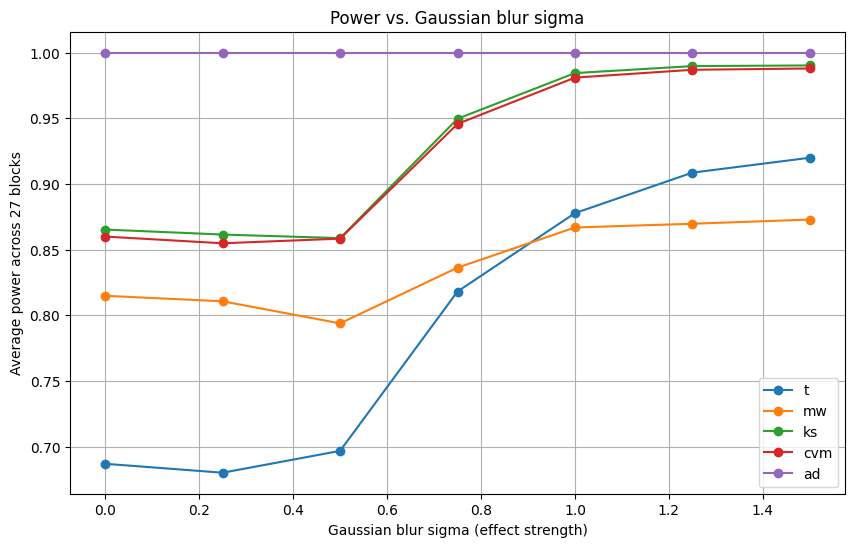

In [2]:
# ====== 1) 可調強度版的 strong_augs: 只改「模糊 σ」這個 effect ======
def strong_augs_blur_only(x, sigma):
    # 其餘強處理關掉，只看 blur 強度
    x2 = gaussian_blur(x, sigma=float(sigma), ksize=5)
    return x2

# ====== 2) 給定強度 -> 估計 power（跨 27 個 block 的平均） ======
from scipy.stats import ttest_ind, mannwhitneyu, ks_2samp, cramervonmises_2samp, anderson_ksamp
import numpy as np

def estimate_power_for_strength(sigma, B=1000, alpha=0.05):
    # 回傳: 每個檢定的「跨 block 平均 power」
    per_test_blockwise = {t: [] for t in TESTS}  # 每個 test 的 27 個值（每個 block 的 power）

    # 先為每個 block 累計拒絕次數
    reject_counts = {t: np.zeros(26, dtype=np.int32) for t in TESTS}

    for _ in range(B):
        base = sample_base_image()             # 同一張基底圖
        x = weak_augs(base)                    # H1 左側：弱擾動
        y = strong_augs_blur_only(base, sigma) # H1 右側：指定 sigma 的強擾動

        acts_x = run_once(x)
        acts_y = run_once(y)

        for i in range(26):
            a = to_np(acts_x[i])
            b = to_np(acts_y[i+1])

            # t
            try:
                if ttest_ind(a, b, equal_var=False).pvalue < alpha:
                    reject_counts["t"][i] += 1
            except: pass
            # MW
            try:
                if mannwhitneyu(a, b, alternative="two-sided").pvalue < alpha:
                    reject_counts["mw"][i] += 1
            except: pass
            # KS
            try:
                if ks_2samp(a, b).pvalue < alpha:
                    reject_counts["ks"][i] += 1
            except: pass
            # CvM
            try:
                if cramervonmises_2samp(a, b).pvalue < alpha:
                    reject_counts["cvm"][i] += 1
            except: pass
            # AD
            try:
                ad = anderson_ksamp([a, b])
                if (ad.significance_level / 100.0) < alpha:
                    reject_counts["ad"][i] += 1
            except: pass

    # 轉成每個 block 的 power，再對 27 blocks 取平均
    avg_power = {}
    for t in TESTS:
        block_power = reject_counts[t] / float(B)  # shape (27,)
        per_test_blockwise[t] = block_power
        avg_power[t] = float(block_power.mean())
    return avg_power, per_test_blockwise  # 回傳平均，也回傳每個 block 的細節

# ====== 3) 掃描多個 σ，畫 Power vs σ 曲線 ======
import matplotlib.pyplot as plt

sigma_list = [0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5]  # 你可再細一點
B_power = 1000
alpha = 0.05

power_curves = {t: [] for t in TESTS}  # 每個 test 的平均 power 曲線
# (可選) 若想保存 block-wise 也可用 dict 存
# blockwise_curves = {t: [] for t in TESTS}

for s in sigma_list:
    avg_power, _ = estimate_power_for_strength(sigma=s, B=B_power, alpha=alpha)
    for t in TESTS:
        power_curves[t].append(avg_power[t])
    print(f"sigma={s}: " + " ".join([f"{t}={avg_power[t]:.3f}" for t in TESTS]))

plt.figure(figsize=(10,6))
for t in TESTS:
    plt.plot(sigma_list, power_curves[t], marker="o", label=t)
plt.xlabel("Gaussian blur sigma (effect strength)")
plt.ylabel("Average power across 27 blocks")
plt.title("Power vs. Gaussian blur sigma")
plt.grid(True)
plt.legend()
plt.show()


 - - 改變 gamma

/tmp/ipykernel_2540472/3614534989.py:48: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad = anderson_ksamp([a, b])
/tmp/ipykernel_2540472/3614534989.py:48: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad = anderson_ksamp([a, b])


Δgamma=0.0: t=0.013 mw=0.025 ks=0.019 cvm=0.024 ad=1.000
Δgamma=0.05: t=0.007 mw=0.020 ks=0.014 cvm=0.020 ad=1.000
Δgamma=0.1: t=0.012 mw=0.033 ks=0.020 cvm=0.032 ad=1.000
Δgamma=0.15: t=0.014 mw=0.024 ks=0.016 cvm=0.023 ad=1.000
Δgamma=0.2: t=0.016 mw=0.032 ks=0.024 cvm=0.031 ad=1.000
Δgamma=0.25: t=0.013 mw=0.026 ks=0.016 cvm=0.024 ad=1.000
Δgamma=0.3: t=0.013 mw=0.034 ks=0.024 cvm=0.032 ad=1.000


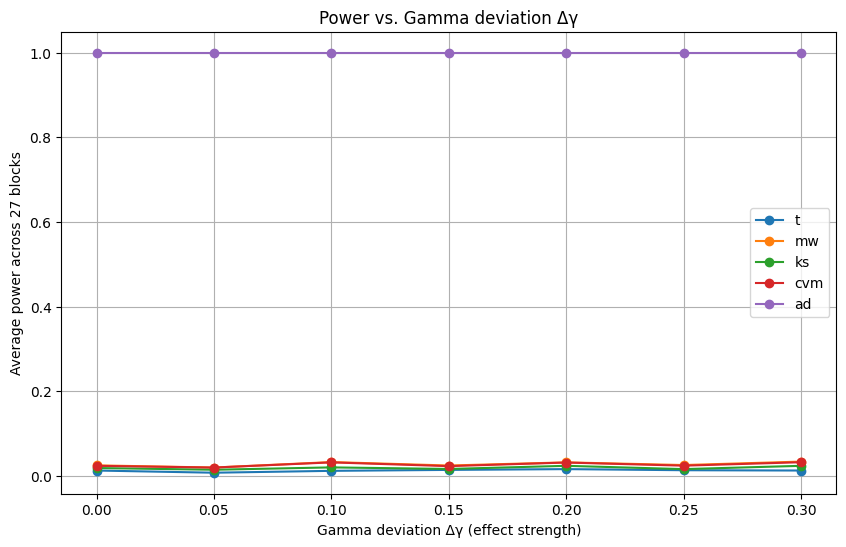

In [36]:
# ====== 1) 可調強度版的 strong_augs: 只改「Gamma 調整」這個 effect ======
def strong_augs_gamma_only(x, delta_gamma):
    """
    x: tensor，值域假設在 [-1, 1]
    delta_gamma: 偏離 1 的幅度，例如 0.0 表示 gamma=1（無變化），
                 0.3 表示 gamma 在 [0.7, 1.3] 之間隨機取值
    """
    gamma = float(np.random.uniform(1 - delta_gamma, 1 + delta_gamma))
    x2 = (x + 1.0) / 2.0          # [-1,1] -> [0,1]
    x2 = torch.clamp(x2, 0, 1) ** gamma
    x2 = x2 * 2.0 - 1.0           # [0,1] -> [-1,1]
    return x2

# ====== 2) 給定強度 -> 估計 power（跨 27 個 block 的平均） ======
def estimate_power_for_strength_gamma(delta_gamma, B=100, alpha=0.05):
    per_test_blockwise = {t: [] for t in TESTS}
    reject_counts = {t: np.zeros(27, dtype=np.int32) for t in TESTS}

    for _ in range(B):
        base = sample_base_image()                   # 同一張基底圖
        x = weak_augs(base)                          # H1 左側：弱擾動
        y = strong_augs_gamma_only(base, delta_gamma) # H1 右側：指定 gamma 強度

        acts_x = run_once(x)
        acts_y = run_once(y)

        for i in range(27):
            a = to_np(acts_x[i])
            b = to_np(acts_y[i])

            try:
                if ttest_ind(a, b, equal_var=False).pvalue < alpha:
                    reject_counts["t"][i] += 1
            except: pass
            try:
                if mannwhitneyu(a, b, alternative="two-sided").pvalue < alpha:
                    reject_counts["mw"][i] += 1
            except: pass
            try:
                if ks_2samp(a, b).pvalue < alpha:
                    reject_counts["ks"][i] += 1
            except: pass
            try:
                if cramervonmises_2samp(a, b).pvalue < alpha:
                    reject_counts["cvm"][i] += 1
            except: pass
            try:
                ad = anderson_ksamp([a, b])
                if (ad.significance_level / 100.0) < alpha:
                    reject_counts["ad"][i] += 1
            except: pass

    avg_power = {}
    for t in TESTS:
        block_power = reject_counts[t] / float(B)
        per_test_blockwise[t] = block_power
        avg_power[t] = float(block_power.mean())
    return avg_power, per_test_blockwise

# ====== 3) 掃描多個 Δgamma，畫 Power vs Δgamma 曲線 ======
gamma_list = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
B_power = 100
alpha = 0.05

power_curves = {t: [] for t in TESTS}

for g in gamma_list:
    avg_power, _ = estimate_power_for_strength_gamma(delta_gamma=g, B=B_power, alpha=alpha)
    for t in TESTS:
        power_curves[t].append(avg_power[t])
    print(f"Δgamma={g}: " + " ".join([f"{t}={avg_power[t]:.3f}" for t in TESTS]))

plt.figure(figsize=(10,6))
for t in TESTS:
    plt.plot(gamma_list, power_curves[t], marker="o", label=t)
plt.xlabel("Gamma deviation Δγ (effect strength)")
plt.ylabel("Average power across 27 blocks")
plt.title("Power vs. Gamma deviation Δγ")
plt.grid(True)
plt.legend()
plt.show()


/tmp/ipykernel_2540472/68430036.py:37: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad = anderson_ksamp([a,b])
/tmp/ipykernel_2540472/68430036.py:37: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad = anderson_ksamp([a,b])


S=0.00 (gamma ~ [1.00, 1.00]): t=0.013 mw=0.033 ks=0.024 cvm=0.033 ad=1.000
S=0.20 (gamma ~ [0.82, 1.22]): t=0.010 mw=0.023 ks=0.016 cvm=0.024 ad=1.000
S=0.50 (gamma ~ [0.61, 1.65]): t=0.012 mw=0.024 ks=0.017 cvm=0.026 ad=1.000
S=1.00 (gamma ~ [0.37, 2.72]): t=0.025 mw=0.031 ks=0.047 cvm=0.046 ad=1.000
S=1.50 (gamma ~ [0.22, 4.48]): t=0.074 mw=0.081 ks=0.136 cvm=0.138 ad=1.000


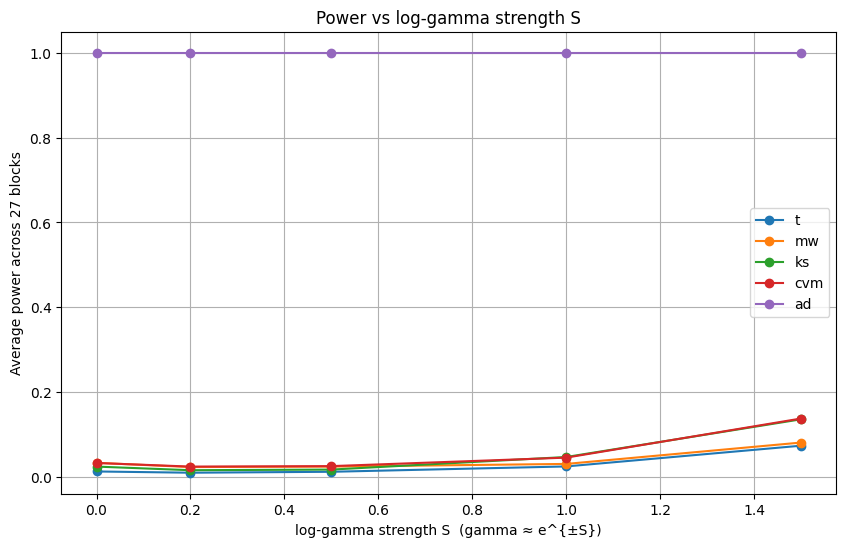

In [37]:
# --- 只改 Gamma 的強處理：用 log-gamma 參數化 ---
def strong_augs_gamma_log_only(x, S):
    """
    S >= 0 為強度；實際 gamma = exp(u)，其中 u ~ Uniform([-S, +S]).
    S=0 -> gamma=1 (無變化)；S↑ -> gamma 在更寬的區間波動。
    """
    u = float(np.random.uniform(-S, +S))
    gamma = math.exp(u)
    x2 = (x + 1.0) / 2.0
    x2 = torch.clamp(x2, 0, 1) ** gamma
    x2 = x2 * 2.0 - 1.0
    return x2

def estimate_power_for_strength_gamma_log(S, B=100, alpha=0.05):
    reject_counts = {t: np.zeros(27, dtype=np.int32) for t in TESTS}
    for _ in range(B):
        base = sample_base_image()
        x = weak_augs(base)
        y = strong_augs_gamma_log_only(base, S)

        acts_x = run_once(x); acts_y = run_once(y)
        for i in range(27):
            a = to_np(acts_x[i]); b = to_np(acts_y[i])
            try:
                if ttest_ind(a,b,equal_var=False).pvalue < alpha: reject_counts["t"][i] += 1
            except: pass
            try:
                if mannwhitneyu(a,b,alternative="two-sided").pvalue < alpha: reject_counts["mw"][i] += 1
            except: pass
            try:
                if ks_2samp(a,b).pvalue < alpha: reject_counts["ks"][i] += 1
            except: pass
            try:
                if cramervonmises_2samp(a,b).pvalue < alpha: reject_counts["cvm"][i] += 1
            except: pass
            try:
                ad = anderson_ksamp([a,b])
                if (ad.significance_level / 100.0) < alpha: reject_counts["ad"][i] += 1
            except: pass

    avg_power = {t: float((reject_counts[t] / float(B)).mean()) for t in TESTS}
    return avg_power

# 掃 S：例如 S=0, 0.2, 0.5, 1.0, 1.5  (gamma 範圍對應約 e^{-S} ~ e^{+S})
S_list = [0.0, 0.2, 0.5, 1.0, 1.5]
B_power = 100; alpha = 0.05

power_curves = {t: [] for t in TESTS}
for S in S_list:
    avg_power = estimate_power_for_strength_gamma_log(S, B=B_power, alpha=alpha)
    for t in TESTS: power_curves[t].append(avg_power[t])
    print(f"S={S:.2f} (gamma ~ [{math.exp(-S):.2f}, {math.exp(S):.2f}]): " +
          " ".join([f"{t}={avg_power[t]:.3f}" for t in TESTS]))

plt.figure(figsize=(10,6))
for t in TESTS:
    plt.plot(S_list, power_curves[t], marker="o", label=t)
plt.xlabel("log-gamma strength S  (gamma ≈ e^{±S})")
plt.ylabel("Average power across 27 blocks")
plt.title("Power vs log-gamma strength S")
plt.grid(True); plt.legend(); plt.show()


/tmp/ipykernel_2540472/3691718745.py:33: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad = anderson_ksamp([a,b])
/tmp/ipykernel_2540472/3691718745.py:33: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad = anderson_ksamp([a,b])


Δgamma=0.0 (gamma≈[1.00, 1.00]): t=0.011 mw=0.024 ks=0.017 cvm=0.026 ad=1.000
Δgamma=0.5 (gamma≈[0.50, 1.50]): t=0.010 mw=0.027 ks=0.019 cvm=0.025 ad=1.000
Δgamma=1.0 (gamma≈[0.05, 2.00]): t=0.057 mw=0.068 ks=0.104 cvm=0.107 ad=1.000
Δgamma=1.5 (gamma≈[0.05, 2.50]): t=0.051 mw=0.066 ks=0.101 cvm=0.102 ad=1.000
Δgamma=2.0 (gamma≈[0.05, 3.00]): t=0.048 mw=0.048 ks=0.084 cvm=0.068 ad=1.000


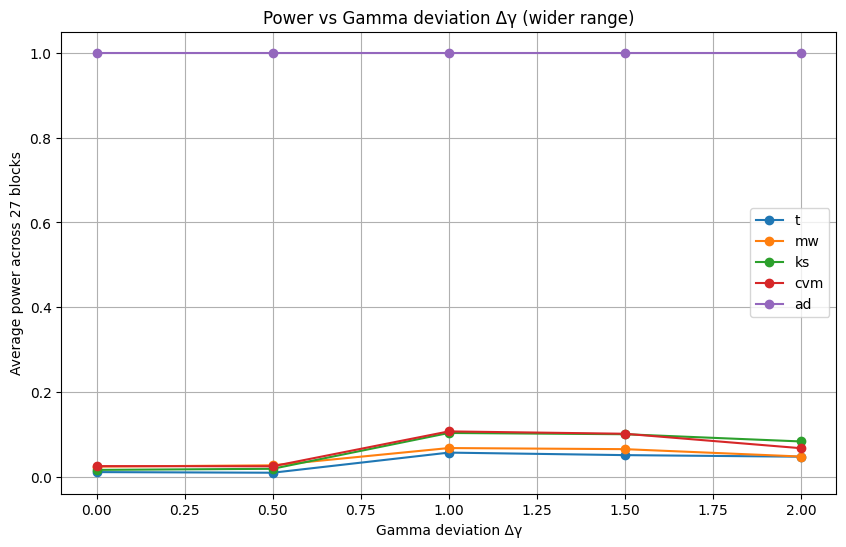

In [38]:
def strong_augs_gamma_only(x, delta_gamma, min_gamma=0.05):
    lo = max(1.0 - delta_gamma, min_gamma)  # 夾下界，避免<=0
    hi = 1.0 + delta_gamma
    gamma = float(np.random.uniform(lo, hi))
    x2 = (x + 1.0)/2.0
    x2 = torch.clamp(x2, 0, 1) ** gamma
    x2 = x2 * 2.0 - 1.0
    return x2

def estimate_power_for_strength_gamma(delta_gamma, B=100, alpha=0.05):
    reject_counts = {t: np.zeros(27, dtype=np.int32) for t in TESTS}
    for _ in range(B):
        base = sample_base_image()
        x = weak_augs(base)
        y = strong_augs_gamma_only(base, delta_gamma)

        acts_x = run_once(x); acts_y = run_once(y)
        for i in range(27):
            a = to_np(acts_x[i]); b = to_np(acts_y[i])
            try:
                if ttest_ind(a,b,equal_var=False).pvalue < alpha: reject_counts["t"][i] += 1
            except: pass
            try:
                if mannwhitneyu(a,b,alternative="two-sided").pvalue < alpha: reject_counts["mw"][i] += 1
            except: pass
            try:
                if ks_2samp(a,b).pvalue < alpha: reject_counts["ks"][i] += 1
            except: pass
            try:
                if cramervonmises_2samp(a,b).pvalue < alpha: reject_counts["cvm"][i] += 1
            except: pass
            try:
                ad = anderson_ksamp([a,b])
                if (ad.significance_level / 100.0) < alpha: reject_counts["ad"][i] += 1
            except: pass

    return {t: float((reject_counts[t] / float(B)).mean()) for t in TESTS}

gamma_list = [0.0, 0.5, 1.0, 1.5, 2.0]  # 很大了
power_curves = {t: [] for t in TESTS}
for g in gamma_list:
    avg_power = estimate_power_for_strength_gamma(g, B=B_power, alpha=alpha)
    for t in TESTS: power_curves[t].append(avg_power[t])
    print(f"Δgamma={g} (gamma≈[{max(1-g,0.05):.2f}, {1+g:.2f}]): " +
          " ".join([f"{t}={avg_power[t]:.3f}" for t in TESTS]))

plt.figure(figsize=(10,6))
for t in TESTS:
    plt.plot(gamma_list, power_curves[t], marker="o", label=t)
plt.xlabel("Gamma deviation Δγ")
plt.ylabel("Average power across 27 blocks")
plt.title("Power vs Gamma deviation Δγ (wider range)")
plt.grid(True); plt.legend(); plt.show()


 - - 改變對比度

/tmp/ipykernel_2540472/2027911159.py:39: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad = anderson_ksamp([a, b])
/tmp/ipykernel_2540472/2027911159.py:39: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad = anderson_ksamp([a, b])
/home/hsujenlung/miniconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:579: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


S=0.00 (scale≈[1.00, 1.00]): t=0.011 mw=0.023 ks=0.017 cvm=0.024 ad=1.000
S=0.20 (scale≈[0.82, 1.22]): t=0.045 mw=0.029 ks=0.045 cvm=0.054 ad=1.000
S=0.50 (scale≈[0.61, 1.65]): t=0.208 mw=0.084 ks=0.240 cvm=0.265 ad=1.000
S=1.00 (scale≈[0.37, 2.72]): t=0.374 mw=0.215 ks=0.420 cvm=0.435 ad=1.000
S=2.00 (scale≈[0.14, 7.39]): t=0.553 mw=0.337 ks=0.581 cvm=0.603 ad=1.000
S=3.00 (scale≈[0.05, 20.09]): t=0.599 mw=0.406 ks=0.650 cvm=0.681 ad=1.000
S=5.00 (scale≈[0.01, 148.41]): t=0.613 mw=0.438 ks=0.700 cvm=0.719 ad=1.000


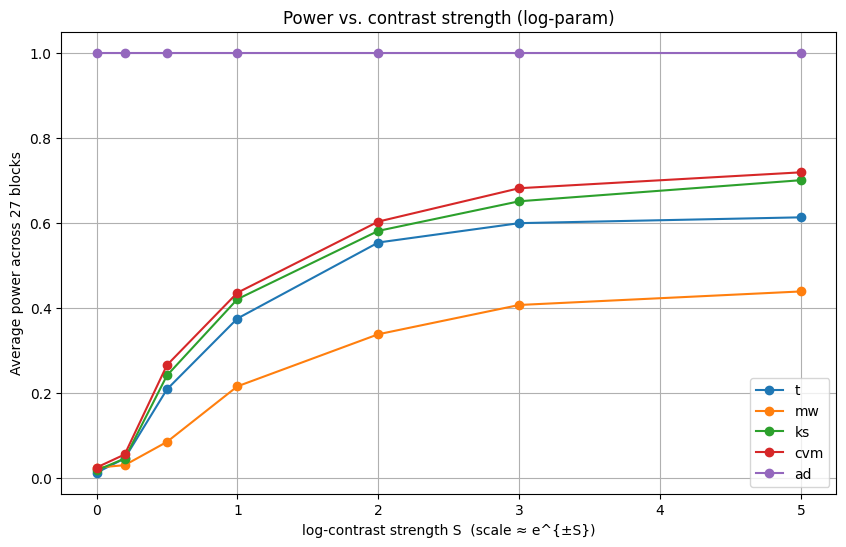

In [41]:
import math
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu, ks_2samp, cramervonmises_2samp, anderson_ksamp
import matplotlib.pyplot as plt

# 1) 只改對比度（log 參數化）
def strong_augs_contrast_log_only(x, S):
    """
    S >= 0；實際縮放因子 scale = exp(u)，u ~ Uniform([-S, +S]).
    """
    u = float(np.random.uniform(-S, +S))
    scale = math.exp(u)
    x2 = x * scale
    return x2.clamp(-1, 1)

# 2) 固定強度 -> 估計「跨 27 blocks 平均」power
def estimate_power_for_strength_contrast_log(S, B=100, alpha=0.05):
    reject = {t: np.zeros(27, dtype=np.int32) for t in TESTS}
    for _ in range(B):
        base = sample_base_image()
        x = weak_augs(base)                       # 左邊：弱擾動
        y = strong_augs_contrast_log_only(base, S)  # 右邊：指定 S 的對比度
        acts_x = run_once(x); acts_y = run_once(y)
        for i in range(27):
            a = to_np(acts_x[i]); b = to_np(acts_y[i])
            try:
                if ttest_ind(a, b, equal_var=False).pvalue < alpha: reject["t"][i] += 1
            except: pass
            try:
                if mannwhitneyu(a, b, alternative="two-sided").pvalue < alpha: reject["mw"][i] += 1
            except: pass
            try:
                if ks_2samp(a, b).pvalue < alpha: reject["ks"][i] += 1
            except: pass
            try:
                if cramervonmises_2samp(a, b).pvalue < alpha: reject["cvm"][i] += 1
            except: pass
            try:
                ad = anderson_ksamp([a, b])
                if (ad.significance_level / 100.0) < alpha: reject["ad"][i] += 1
            except: pass
    return {t: float((reject[t] / float(B)).mean()) for t in TESTS}

# 3) 掃 S（例：S=0, 0.2, 0.5, 1.0 對應 scale ≈ e^{±S}）
S_list = [0.0, 0.2, 0.5, 1.0, 2.0, 3.0, 5.0]
B_power = 100; alpha = 0.05
power_curves = {t: [] for t in TESTS}

for S in S_list:
    avg_power = estimate_power_for_strength_contrast_log(S, B=B_power, alpha=alpha)
    for t in TESTS: power_curves[t].append(avg_power[t])
    print(f"S={S:.2f} (scale≈[{math.exp(-S):.2f}, {math.exp(S):.2f}]): " +
          " ".join([f"{t}={avg_power[t]:.3f}" for t in TESTS]))

plt.figure(figsize=(10,6))
for t in TESTS:
    plt.plot(S_list, power_curves[t], marker="o", label=t)
plt.xlabel("log-contrast strength S  (scale ≈ e^{±S})")
plt.ylabel("Average power across 27 blocks")
plt.title("Power vs. contrast strength (log-param)")
plt.grid(True); plt.legend(); plt.show()


/tmp/ipykernel_2540472/4226520415.py:30: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad = anderson_ksamp([a, b])


/home/hsujenlung/miniconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:579: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/tmp/ipykernel_2540472/4226520415.py:30: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad = anderson_ksamp([a, b])


Δc=0.00 (scale≈[1.00, 1.00]): t=0.014 mw=0.026 ks=0.020 cvm=0.026 ad=1.000
Δc=0.10 (scale≈[0.90, 1.10]): t=0.019 mw=0.027 ks=0.020 cvm=0.027 ad=1.000
Δc=0.25 (scale≈[0.75, 1.25]): t=0.097 mw=0.034 ks=0.097 cvm=0.117 ad=1.000
Δc=0.50 (scale≈[0.50, 1.50]): t=0.181 mw=0.082 ks=0.212 cvm=0.233 ad=1.000
Δc=0.75 (scale≈[0.25, 1.75]): t=0.337 mw=0.204 ks=0.385 cvm=0.408 ad=1.000
Δc=1.00 (scale≈[0.05, 2.00]): t=0.356 mw=0.235 ks=0.404 cvm=0.414 ad=1.000
Δc=2.00 (scale≈[0.05, 3.00]): t=0.347 mw=0.187 ks=0.419 cvm=0.437 ad=1.000
Δc=3.00 (scale≈[0.05, 4.00]): t=0.392 mw=0.188 ks=0.470 cvm=0.495 ad=1.000


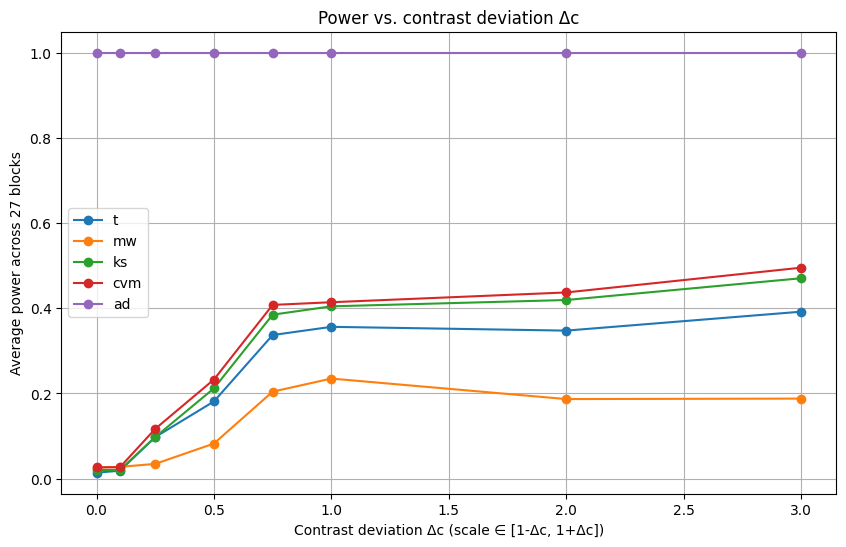

In [42]:
def strong_augs_contrast_only(x, delta_c, min_scale=0.05):
    lo = max(1.0 - delta_c, min_scale)
    hi = 1.0 + delta_c
    scale = float(np.random.uniform(lo, hi))
    x2 = x * scale
    return x2.clamp(-1, 1)

def estimate_power_for_strength_contrast(delta_c, B=100, alpha=0.05):
    reject = {t: np.zeros(27, dtype=np.int32) for t in TESTS}
    for _ in range(B):
        base = sample_base_image()
        x = weak_augs(base)
        y = strong_augs_contrast_only(base, delta_c)
        acts_x = run_once(x); acts_y = run_once(y)
        for i in range(27):
            a = to_np(acts_x[i]); b = to_np(acts_y[i])
            try:
                if ttest_ind(a, b, equal_var=False).pvalue < alpha: reject["t"][i] += 1
            except: pass
            try:
                if mannwhitneyu(a, b, alternative="two-sided").pvalue < alpha: reject["mw"][i] += 1
            except: pass
            try:
                if ks_2samp(a, b).pvalue < alpha: reject["ks"][i] += 1
            except: pass
            try:
                if cramervonmises_2samp(a, b).pvalue < alpha: reject["cvm"][i] += 1
            except: pass
            try:
                ad = anderson_ksamp([a, b])
                if (ad.significance_level / 100.0) < alpha: reject["ad"][i] += 1
            except: pass
    return {t: float((reject[t] / float(B)).mean()) for t in TESTS}

delta_list = [0.0, 0.1, 0.25, 0.5, 0.75, 1.0, 2.0, 3.0]  # Δc 很大時會有飽和，正常
power_curves = {t: [] for t in TESTS}
for dc in delta_list:
    avg_power = estimate_power_for_strength_contrast(dc, B=B_power, alpha=alpha)
    for t in TESTS: power_curves[t].append(avg_power[t])
    print(f"Δc={dc:.2f} (scale≈[{max(1-dc,0.05):.2f}, {1+dc:.2f}]): " +
          " ".join([f"{t}={avg_power[t]:.3f}" for t in TESTS]))

plt.figure(figsize=(10,6))
for t in TESTS:
    plt.plot(delta_list, power_curves[t], marker="o", label=t)
plt.xlabel("Contrast deviation Δc (scale ∈ [1-Δc, 1+Δc])")
plt.ylabel("Average power across 27 blocks")
plt.title("Power vs. contrast deviation Δc")
plt.grid(True); plt.legend(); plt.show()
